# Initialization
credits: https://www.kaggle.com/rejpalcz/gapnet-pl-lb-0-385

In [1]:
import sys
import numpy as np
import keras
from keras.utils import Sequence
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import imgaug as ia
from imgaug import augmenters as iaa
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf
from tensorflow import set_random_seed
from sklearn.metrics import f1_score as off1

Using TensorFlow backend.


In [2]:
# Global parameters
BATCH_SIZE = 32         # num of images per batch
NUM_CLASS = 28          # num of classes
SEED = 777
SHAPE = (512, 512, 4)   # shape of image  
DIR = 'C:\kaggle/'
VAL_RATIO = 0.2         # 20 % as validation

ia.seed(SEED)
set_random_seed(SEED)

In [3]:
# Data Set
def getTrainDataset():
    path_to_train = DIR + 'train/'
    data = pd.read_csv(DIR + 'train.csv')
    paths = []
    labels = []
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(NUM_CLASS)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)
    return np.array(paths), np.array(labels)

def getTestDataset():
    path_to_test = DIR + 'test/'
    data = pd.read_csv(DIR + 'sample_submission.csv')
    paths = []
    labels = []
    for name in data['Id']:
        y = np.ones(NUM_CLASS)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)
    return np.array(paths), np.array(labels)

In [4]:
# Data Generator
class ProteinDataGenerator(keras.utils.Sequence):        
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]
        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)
        y = self.labels[indexes]      
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0, 0.5))),
                    iaa.ContrastNormalization((0.75, 1.5)),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')

        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        
        im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
        im = np.divide(im, 255)
        return im

In [5]:
# Evaluation criteria: f1 score
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [6]:
# CNN
def create_model(input_shape):
    dropRate = 0.25
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(32, (3, 3))(x) #, strides=(2,2))(x)
    x = ReLU()(x)

    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    ginp1 = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(ginp1)
    x = Conv2D(64, (3, 3), strides=(2,2))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    ginp2 = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(ginp2)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    ginp3 = Dropout(dropRate)(x)
    
    gap1 = GlobalAveragePooling2D()(ginp1)
    gap2 = GlobalAveragePooling2D()(ginp2)
    gap3 = GlobalAveragePooling2D()(ginp3)
    
    x = Concatenate()([gap1, gap2, gap3])
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    x = Dense(NUM_CLASS)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model

In [7]:
# Get probability threshold for each class based on f1 score 
def getOptimalT(mdl, fullValGen):
    lastFullValPred = np.empty((0, NUM_CLASS))
    lastFullValLabels = np.empty((0, NUM_CLASS))
    for i in tqdm(range(len(fullValGen))): 
        im, lbl = fullValGen[i]
        scores = mdl.predict(im)
        lastFullValPred = np.append(lastFullValPred, scores, axis=0)
        lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)    
    rng = np.arange(0, 1, 0.001)
    f1s = np.zeros((rng.shape[0], NUM_CLASS))
    for j,t in enumerate(tqdm(rng)):
        for i in range(NUM_CLASS):
            p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
            scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
            f1s[j,i] = scoref1  
    T = np.empty(NUM_CLASS)
    for i in range(NUM_CLASS):
        T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
    print(T)
    
    return T

# Training

In [8]:
# Create data train for training and validation
paths, labels = getTrainDataset()

keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])   

pathsTrain = paths[0:lastTrainIndex]      # Genearate training dataset indexes
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]         # Genearate valdation dataset indexes
labelsVal = labels[lastTrainIndex:]

# Data train for training and validation data
trg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache = False, augment = False, shuffle = True)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=False, shuffle = False)

checkpoint = ModelCheckpoint(DIR + 'GapNet.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

In [9]:
# Create model
model = create_model(SHAPE)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 510, 510, 32) 1184        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 510, 510, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 28)           7196        dropout_5[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28)           0           dense_3[0][0]                    
Total params: 597,388
Trainable params: 595,268
Non-trainable params: 2,120
__________________________________________________________________________________________________


In [10]:
# Train model
epochs = 100

hist = model.fit_generator(
    trg,
    steps_per_epoch=100,
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=False,
    workers=1,
    verbose=1,
    callbacks=[checkpoint,reduceLROnPlato])

Epoch 1/100
100/100 [==============================] - ETA: 13:26 - loss: 0.7996 - acc: 0.4788 - f1: 0.089 - ETA: 7:10 - loss: 0.7821 - acc: 0.5117 - f1: 0.086 - ETA: 5:05 - loss: 0.7454 - acc: 0.5450 - f1: 0.08 - ETA: 4:02 - loss: 0.7129 - acc: 0.5751 - f1: 0.08 - ETA: 3:24 - loss: 0.6848 - acc: 0.6033 - f1: 0.08 - ETA: 2:58 - loss: 0.6593 - acc: 0.6276 - f1: 0.08 - ETA: 2:39 - loss: 0.6354 - acc: 0.6502 - f1: 0.08 - ETA: 2:25 - loss: 0.6120 - acc: 0.6729 - f1: 0.08 - ETA: 2:14 - loss: 0.5876 - acc: 0.6946 - f1: 0.08 - ETA: 2:05 - loss: 0.5658 - acc: 0.7150 - f1: 0.08 - ETA: 1:57 - loss: 0.5460 - acc: 0.7323 - f1: 0.08 - ETA: 1:52 - loss: 0.5281 - acc: 0.7471 - f1: 0.08 - ETA: 1:49 - loss: 0.5107 - acc: 0.7600 - f1: 0.08 - ETA: 1:47 - loss: 0.4941 - acc: 0.7716 - f1: 0.08 - ETA: 1:45 - loss: 0.4809 - acc: 0.7818 - f1: 0.07 - ETA: 1:43 - loss: 0.4666 - acc: 0.7910 - f1: 0.08 - ETA: 1:41 - loss: 0.4541 - acc: 0.7995 - f1: 0.08 - ETA: 1:40 - loss: 0.4412 - acc: 0.8070 - f1: 0.07 - ETA: 1

100/100 [==============================] - ETA: 1:03 - loss: 0.1889 - acc: 0.9364 - f1: 0.07 - ETA: 1:02 - loss: 0.1849 - acc: 0.9397 - f1: 0.07 - ETA: 1:02 - loss: 0.1828 - acc: 0.9420 - f1: 0.06 - ETA: 1:02 - loss: 0.1759 - acc: 0.9434 - f1: 0.07 - ETA: 1:01 - loss: 0.1725 - acc: 0.9446 - f1: 0.07 - ETA: 1:01 - loss: 0.1750 - acc: 0.9446 - f1: 0.07 - ETA: 1:00 - loss: 0.1749 - acc: 0.9445 - f1: 0.07 - ETA: 59s - loss: 0.1733 - acc: 0.9443 - f1: 0.0730 - ETA: 59s - loss: 0.1699 - acc: 0.9458 - f1: 0.074 - ETA: 58s - loss: 0.1721 - acc: 0.9454 - f1: 0.075 - ETA: 58s - loss: 0.1735 - acc: 0.9452 - f1: 0.074 - ETA: 57s - loss: 0.1735 - acc: 0.9456 - f1: 0.075 - ETA: 56s - loss: 0.1760 - acc: 0.9449 - f1: 0.075 - ETA: 55s - loss: 0.1795 - acc: 0.9442 - f1: 0.075 - ETA: 54s - loss: 0.1785 - acc: 0.9444 - f1: 0.075 - ETA: 54s - loss: 0.1789 - acc: 0.9444 - f1: 0.074 - ETA: 53s - loss: 0.1778 - acc: 0.9443 - f1: 0.074 - ETA: 52s - loss: 0.1780 - acc: 0.9443 - f1: 0.074 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:04 - loss: 0.1483 - acc: 0.9554 - f1: 0.07 - ETA: 1:03 - loss: 0.1501 - acc: 0.9509 - f1: 0.07 - ETA: 1:03 - loss: 0.1515 - acc: 0.9509 - f1: 0.07 - ETA: 1:01 - loss: 0.1525 - acc: 0.9517 - f1: 0.08 - ETA: 1:01 - loss: 0.1576 - acc: 0.9498 - f1: 0.07 - ETA: 1:01 - loss: 0.1599 - acc: 0.9494 - f1: 0.07 - ETA: 1:00 - loss: 0.1582 - acc: 0.9493 - f1: 0.07 - ETA: 59s - loss: 0.1592 - acc: 0.9489 - f1: 0.0774 - ETA: 58s - loss: 0.1579 - acc: 0.9489 - f1: 0.077 - ETA: 58s - loss: 0.1592 - acc: 0.9484 - f1: 0.078 - ETA: 57s - loss: 0.1602 - acc: 0.9483 - f1: 0.079 - ETA: 57s - loss: 0.1612 - acc: 0.9479 - f1: 0.079 - ETA: 56s - loss: 0.1609 - acc: 0.9477 - f1: 0.079 - ETA: 55s - loss: 0.1627 - acc: 0.9467 - f1: 0.078 - ETA: 54s - loss: 0.1614 - acc: 0.9472 - f1: 0.077 - ETA: 54s - loss: 0.1626 - acc: 0.9469 - f1: 0.078 - ETA: 53s - loss: 0.1632 - acc: 0.9464 - f1: 0.078 - ETA: 52s - loss: 0.1636 - acc: 0.9464 - f1: 0.078 - ETA: 52s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1783 - acc: 0.9408 - f1: 0.08 - ETA: 1:01 - loss: 0.1649 - acc: 0.9442 - f1: 0.08 - ETA: 1:01 - loss: 0.1687 - acc: 0.9435 - f1: 0.08 - ETA: 1:00 - loss: 0.1685 - acc: 0.9450 - f1: 0.08 - ETA: 1:01 - loss: 0.1692 - acc: 0.9451 - f1: 0.08 - ETA: 1:00 - loss: 0.1658 - acc: 0.9453 - f1: 0.08 - ETA: 1:00 - loss: 0.1658 - acc: 0.9460 - f1: 0.08 - ETA: 59s - loss: 0.1639 - acc: 0.9467 - f1: 0.0826 - ETA: 58s - loss: 0.1660 - acc: 0.9457 - f1: 0.082 - ETA: 58s - loss: 0.1679 - acc: 0.9455 - f1: 0.083 - ETA: 57s - loss: 0.1673 - acc: 0.9454 - f1: 0.082 - ETA: 56s - loss: 0.1649 - acc: 0.9457 - f1: 0.082 - ETA: 55s - loss: 0.1653 - acc: 0.9458 - f1: 0.080 - ETA: 54s - loss: 0.1648 - acc: 0.9459 - f1: 0.081 - ETA: 54s - loss: 0.1650 - acc: 0.9459 - f1: 0.081 - ETA: 53s - loss: 0.1649 - acc: 0.9464 - f1: 0.080 - ETA: 52s - loss: 0.1654 - acc: 0.9466 - f1: 0.080 - ETA: 52s - loss: 0.1658 - acc: 0.9465 - f1: 0.080 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:05 - loss: 0.1695 - acc: 0.9397 - f1: 0.06 - ETA: 1:03 - loss: 0.1603 - acc: 0.9431 - f1: 0.07 - ETA: 1:02 - loss: 0.1631 - acc: 0.9453 - f1: 0.07 - ETA: 1:01 - loss: 0.1687 - acc: 0.9456 - f1: 0.07 - ETA: 1:00 - loss: 0.1659 - acc: 0.9460 - f1: 0.07 - ETA: 1:00 - loss: 0.1701 - acc: 0.9438 - f1: 0.07 - ETA: 59s - loss: 0.1713 - acc: 0.9434 - f1: 0.0780 - ETA: 58s - loss: 0.1691 - acc: 0.9438 - f1: 0.078 - ETA: 58s - loss: 0.1665 - acc: 0.9446 - f1: 0.077 - ETA: 57s - loss: 0.1678 - acc: 0.9436 - f1: 0.077 - ETA: 56s - loss: 0.1689 - acc: 0.9430 - f1: 0.077 - ETA: 56s - loss: 0.1673 - acc: 0.9439 - f1: 0.077 - ETA: 55s - loss: 0.1658 - acc: 0.9440 - f1: 0.077 - ETA: 54s - loss: 0.1672 - acc: 0.9436 - f1: 0.077 - ETA: 54s - loss: 0.1680 - acc: 0.9432 - f1: 0.078 - ETA: 53s - loss: 0.1666 - acc: 0.9438 - f1: 0.078 - ETA: 52s - loss: 0.1659 - acc: 0.9442 - f1: 0.078 - ETA: 52s - loss: 0.1662 - acc: 0.9445 - f1: 0.079 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:04 - loss: 0.1633 - acc: 0.9442 - f1: 0.09 - ETA: 1:03 - loss: 0.1563 - acc: 0.9442 - f1: 0.09 - ETA: 1:02 - loss: 0.1592 - acc: 0.9453 - f1: 0.09 - ETA: 1:01 - loss: 0.1592 - acc: 0.9459 - f1: 0.08 - ETA: 1:00 - loss: 0.1611 - acc: 0.9467 - f1: 0.08 - ETA: 59s - loss: 0.1591 - acc: 0.9477 - f1: 0.0874 - ETA: 59s - loss: 0.1568 - acc: 0.9491 - f1: 0.087 - ETA: 58s - loss: 0.1567 - acc: 0.9484 - f1: 0.087 - ETA: 57s - loss: 0.1569 - acc: 0.9487 - f1: 0.088 - ETA: 57s - loss: 0.1599 - acc: 0.9482 - f1: 0.086 - ETA: 56s - loss: 0.1607 - acc: 0.9475 - f1: 0.087 - ETA: 56s - loss: 0.1584 - acc: 0.9483 - f1: 0.086 - ETA: 55s - loss: 0.1589 - acc: 0.9479 - f1: 0.086 - ETA: 54s - loss: 0.1578 - acc: 0.9479 - f1: 0.087 - ETA: 53s - loss: 0.1586 - acc: 0.9479 - f1: 0.085 - ETA: 53s - loss: 0.1581 - acc: 0.9482 - f1: 0.085 - ETA: 52s - loss: 0.1575 - acc: 0.9485 - f1: 0.085 - ETA: 51s - loss: 0.1575 - acc: 0.9485 - f1: 0.085 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1537 - acc: 0.9453 - f1: 0.09 - ETA: 1:01 - loss: 0.1541 - acc: 0.9459 - f1: 0.08 - ETA: 1:00 - loss: 0.1614 - acc: 0.9453 - f1: 0.08 - ETA: 1:01 - loss: 0.1611 - acc: 0.9464 - f1: 0.08 - ETA: 1:00 - loss: 0.1607 - acc: 0.9460 - f1: 0.08 - ETA: 59s - loss: 0.1650 - acc: 0.9455 - f1: 0.0889 - ETA: 59s - loss: 0.1629 - acc: 0.9463 - f1: 0.089 - ETA: 58s - loss: 0.1635 - acc: 0.9467 - f1: 0.087 - ETA: 57s - loss: 0.1625 - acc: 0.9467 - f1: 0.086 - ETA: 57s - loss: 0.1638 - acc: 0.9465 - f1: 0.085 - ETA: 56s - loss: 0.1625 - acc: 0.9469 - f1: 0.085 - ETA: 56s - loss: 0.1640 - acc: 0.9464 - f1: 0.084 - ETA: 55s - loss: 0.1629 - acc: 0.9469 - f1: 0.084 - ETA: 54s - loss: 0.1614 - acc: 0.9478 - f1: 0.085 - ETA: 54s - loss: 0.1629 - acc: 0.9469 - f1: 0.085 - ETA: 53s - loss: 0.1624 - acc: 0.9470 - f1: 0.085 - ETA: 52s - loss: 0.1631 - acc: 0.9468 - f1: 0.085 - ETA: 51s - loss: 0.1624 - acc: 0.9469 - f1: 0.085 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:01 - loss: 0.1548 - acc: 0.9509 - f1: 0.08 - ETA: 1:01 - loss: 0.1580 - acc: 0.9492 - f1: 0.08 - ETA: 1:00 - loss: 0.1648 - acc: 0.9490 - f1: 0.08 - ETA: 59s - loss: 0.1653 - acc: 0.9478 - f1: 0.0855 - ETA: 59s - loss: 0.1647 - acc: 0.9475 - f1: 0.084 - ETA: 58s - loss: 0.1637 - acc: 0.9475 - f1: 0.085 - ETA: 58s - loss: 0.1607 - acc: 0.9490 - f1: 0.086 - ETA: 57s - loss: 0.1608 - acc: 0.9487 - f1: 0.088 - ETA: 57s - loss: 0.1620 - acc: 0.9478 - f1: 0.089 - ETA: 56s - loss: 0.1621 - acc: 0.9478 - f1: 0.089 - ETA: 56s - loss: 0.1645 - acc: 0.9468 - f1: 0.087 - ETA: 55s - loss: 0.1634 - acc: 0.9466 - f1: 0.088 - ETA: 54s - loss: 0.1618 - acc: 0.9463 - f1: 0.088 - ETA: 54s - loss: 0.1616 - acc: 0.9462 - f1: 0.089 - ETA: 53s - loss: 0.1594 - acc: 0.9471 - f1: 0.089 - ETA: 52s - loss: 0.1598 - acc: 0.9469 - f1: 0.088 - ETA: 52s - loss: 0.1591 - acc: 0.9470 - f1: 0.088 - ETA: 51s - loss: 0.1597 - acc: 0.9467 - f1: 0.088 - ETA: 50s - loss: 0.1

100/100 [==============================] - ETA: 1:01 - loss: 0.1479 - acc: 0.9475 - f1: 0.10 - ETA: 1:00 - loss: 0.1564 - acc: 0.9464 - f1: 0.08 - ETA: 1:00 - loss: 0.1636 - acc: 0.9475 - f1: 0.08 - ETA: 59s - loss: 0.1616 - acc: 0.9478 - f1: 0.0861 - ETA: 59s - loss: 0.1597 - acc: 0.9487 - f1: 0.084 - ETA: 59s - loss: 0.1561 - acc: 0.9492 - f1: 0.084 - ETA: 58s - loss: 0.1557 - acc: 0.9499 - f1: 0.085 - ETA: 57s - loss: 0.1592 - acc: 0.9485 - f1: 0.085 - ETA: 57s - loss: 0.1595 - acc: 0.9477 - f1: 0.087 - ETA: 56s - loss: 0.1583 - acc: 0.9477 - f1: 0.088 - ETA: 55s - loss: 0.1616 - acc: 0.9465 - f1: 0.087 - ETA: 55s - loss: 0.1602 - acc: 0.9473 - f1: 0.087 - ETA: 54s - loss: 0.1615 - acc: 0.9470 - f1: 0.086 - ETA: 54s - loss: 0.1624 - acc: 0.9470 - f1: 0.086 - ETA: 53s - loss: 0.1622 - acc: 0.9467 - f1: 0.087 - ETA: 52s - loss: 0.1616 - acc: 0.9471 - f1: 0.087 - ETA: 51s - loss: 0.1615 - acc: 0.9470 - f1: 0.088 - ETA: 51s - loss: 0.1615 - acc: 0.9471 - f1: 0.087 - ETA: 50s - loss: 0.1

100/100 [==============================] - ETA: 1:01 - loss: 0.1787 - acc: 0.9408 - f1: 0.09 - ETA: 1:01 - loss: 0.1674 - acc: 0.9459 - f1: 0.09 - ETA: 1:01 - loss: 0.1638 - acc: 0.9449 - f1: 0.08 - ETA: 1:01 - loss: 0.1614 - acc: 0.9461 - f1: 0.09 - ETA: 1:00 - loss: 0.1606 - acc: 0.9467 - f1: 0.09 - ETA: 1:00 - loss: 0.1632 - acc: 0.9464 - f1: 0.08 - ETA: 59s - loss: 0.1631 - acc: 0.9469 - f1: 0.0920 - ETA: 58s - loss: 0.1633 - acc: 0.9466 - f1: 0.091 - ETA: 58s - loss: 0.1611 - acc: 0.9474 - f1: 0.092 - ETA: 57s - loss: 0.1610 - acc: 0.9473 - f1: 0.093 - ETA: 57s - loss: 0.1592 - acc: 0.9474 - f1: 0.093 - ETA: 56s - loss: 0.1608 - acc: 0.9469 - f1: 0.093 - ETA: 55s - loss: 0.1593 - acc: 0.9472 - f1: 0.092 - ETA: 54s - loss: 0.1598 - acc: 0.9471 - f1: 0.093 - ETA: 54s - loss: 0.1599 - acc: 0.9469 - f1: 0.092 - ETA: 53s - loss: 0.1587 - acc: 0.9469 - f1: 0.091 - ETA: 52s - loss: 0.1579 - acc: 0.9473 - f1: 0.090 - ETA: 52s - loss: 0.1577 - acc: 0.9479 - f1: 0.090 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1649 - acc: 0.9386 - f1: 0.09 - ETA: 1:02 - loss: 0.1531 - acc: 0.9453 - f1: 0.10 - ETA: 1:01 - loss: 0.1557 - acc: 0.9461 - f1: 0.10 - ETA: 1:01 - loss: 0.1552 - acc: 0.9450 - f1: 0.09 - ETA: 1:00 - loss: 0.1600 - acc: 0.9426 - f1: 0.09 - ETA: 1:00 - loss: 0.1615 - acc: 0.9433 - f1: 0.09 - ETA: 59s - loss: 0.1632 - acc: 0.9434 - f1: 0.0938 - ETA: 58s - loss: 0.1639 - acc: 0.9431 - f1: 0.095 - ETA: 58s - loss: 0.1619 - acc: 0.9443 - f1: 0.095 - ETA: 57s - loss: 0.1589 - acc: 0.9454 - f1: 0.095 - ETA: 56s - loss: 0.1577 - acc: 0.9459 - f1: 0.094 - ETA: 56s - loss: 0.1563 - acc: 0.9459 - f1: 0.096 - ETA: 55s - loss: 0.1545 - acc: 0.9465 - f1: 0.096 - ETA: 54s - loss: 0.1559 - acc: 0.9465 - f1: 0.094 - ETA: 54s - loss: 0.1545 - acc: 0.9471 - f1: 0.093 - ETA: 53s - loss: 0.1540 - acc: 0.9475 - f1: 0.093 - ETA: 52s - loss: 0.1544 - acc: 0.9475 - f1: 0.094 - ETA: 51s - loss: 0.1545 - acc: 0.9477 - f1: 0.094 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:02 - loss: 0.1343 - acc: 0.9565 - f1: 0.10 - ETA: 1:01 - loss: 0.1375 - acc: 0.9542 - f1: 0.09 - ETA: 1:01 - loss: 0.1395 - acc: 0.9531 - f1: 0.09 - ETA: 1:00 - loss: 0.1454 - acc: 0.9509 - f1: 0.09 - ETA: 1:00 - loss: 0.1467 - acc: 0.9504 - f1: 0.09 - ETA: 59s - loss: 0.1527 - acc: 0.9509 - f1: 0.0930 - ETA: 59s - loss: 0.1533 - acc: 0.9506 - f1: 0.094 - ETA: 58s - loss: 0.1531 - acc: 0.9508 - f1: 0.095 - ETA: 57s - loss: 0.1528 - acc: 0.9508 - f1: 0.094 - ETA: 57s - loss: 0.1532 - acc: 0.9498 - f1: 0.094 - ETA: 56s - loss: 0.1529 - acc: 0.9496 - f1: 0.093 - ETA: 55s - loss: 0.1513 - acc: 0.9496 - f1: 0.091 - ETA: 55s - loss: 0.1510 - acc: 0.9497 - f1: 0.091 - ETA: 54s - loss: 0.1499 - acc: 0.9500 - f1: 0.092 - ETA: 53s - loss: 0.1501 - acc: 0.9499 - f1: 0.092 - ETA: 53s - loss: 0.1501 - acc: 0.9501 - f1: 0.092 - ETA: 52s - loss: 0.1502 - acc: 0.9500 - f1: 0.093 - ETA: 51s - loss: 0.1497 - acc: 0.9499 - f1: 0.094 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1456 - acc: 0.9531 - f1: 0.11 - ETA: 1:02 - loss: 0.1471 - acc: 0.9531 - f1: 0.10 - ETA: 1:01 - loss: 0.1413 - acc: 0.9535 - f1: 0.10 - ETA: 1:01 - loss: 0.1437 - acc: 0.9526 - f1: 0.10 - ETA: 1:00 - loss: 0.1462 - acc: 0.9520 - f1: 0.10 - ETA: 59s - loss: 0.1454 - acc: 0.9520 - f1: 0.1071 - ETA: 59s - loss: 0.1432 - acc: 0.9522 - f1: 0.109 - ETA: 58s - loss: 0.1433 - acc: 0.9524 - f1: 0.107 - ETA: 58s - loss: 0.1450 - acc: 0.9516 - f1: 0.106 - ETA: 57s - loss: 0.1470 - acc: 0.9513 - f1: 0.106 - ETA: 57s - loss: 0.1460 - acc: 0.9514 - f1: 0.105 - ETA: 56s - loss: 0.1488 - acc: 0.9502 - f1: 0.104 - ETA: 55s - loss: 0.1470 - acc: 0.9509 - f1: 0.104 - ETA: 54s - loss: 0.1504 - acc: 0.9503 - f1: 0.104 - ETA: 54s - loss: 0.1510 - acc: 0.9500 - f1: 0.103 - ETA: 53s - loss: 0.1504 - acc: 0.9501 - f1: 0.103 - ETA: 52s - loss: 0.1506 - acc: 0.9500 - f1: 0.102 - ETA: 52s - loss: 0.1508 - acc: 0.9498 - f1: 0.102 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:02 - loss: 0.1445 - acc: 0.9531 - f1: 0.11 - ETA: 1:02 - loss: 0.1365 - acc: 0.9548 - f1: 0.11 - ETA: 1:01 - loss: 0.1424 - acc: 0.9550 - f1: 0.11 - ETA: 1:01 - loss: 0.1426 - acc: 0.9551 - f1: 0.11 - ETA: 1:00 - loss: 0.1494 - acc: 0.9520 - f1: 0.10 - ETA: 1:00 - loss: 0.1454 - acc: 0.9528 - f1: 0.10 - ETA: 59s - loss: 0.1446 - acc: 0.9539 - f1: 0.1073 - ETA: 58s - loss: 0.1451 - acc: 0.9534 - f1: 0.106 - ETA: 58s - loss: 0.1464 - acc: 0.9526 - f1: 0.104 - ETA: 57s - loss: 0.1474 - acc: 0.9520 - f1: 0.105 - ETA: 56s - loss: 0.1465 - acc: 0.9523 - f1: 0.106 - ETA: 56s - loss: 0.1445 - acc: 0.9530 - f1: 0.105 - ETA: 55s - loss: 0.1440 - acc: 0.9529 - f1: 0.106 - ETA: 54s - loss: 0.1438 - acc: 0.9530 - f1: 0.105 - ETA: 53s - loss: 0.1433 - acc: 0.9531 - f1: 0.105 - ETA: 53s - loss: 0.1436 - acc: 0.9531 - f1: 0.105 - ETA: 52s - loss: 0.1442 - acc: 0.9526 - f1: 0.104 - ETA: 51s - loss: 0.1439 - acc: 0.9524 - f1: 0.104 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1189 - acc: 0.9576 - f1: 0.11 - ETA: 1:03 - loss: 0.1315 - acc: 0.9559 - f1: 0.11 - ETA: 1:02 - loss: 0.1328 - acc: 0.9550 - f1: 0.11 - ETA: 1:01 - loss: 0.1381 - acc: 0.9528 - f1: 0.11 - ETA: 1:00 - loss: 0.1384 - acc: 0.9520 - f1: 0.11 - ETA: 1:00 - loss: 0.1387 - acc: 0.9520 - f1: 0.11 - ETA: 59s - loss: 0.1369 - acc: 0.9533 - f1: 0.1130 - ETA: 58s - loss: 0.1385 - acc: 0.9528 - f1: 0.111 - ETA: 58s - loss: 0.1387 - acc: 0.9534 - f1: 0.112 - ETA: 57s - loss: 0.1393 - acc: 0.9529 - f1: 0.110 - ETA: 56s - loss: 0.1389 - acc: 0.9527 - f1: 0.110 - ETA: 56s - loss: 0.1399 - acc: 0.9528 - f1: 0.112 - ETA: 55s - loss: 0.1403 - acc: 0.9525 - f1: 0.112 - ETA: 54s - loss: 0.1417 - acc: 0.9522 - f1: 0.111 - ETA: 54s - loss: 0.1420 - acc: 0.9522 - f1: 0.111 - ETA: 53s - loss: 0.1427 - acc: 0.9517 - f1: 0.111 - ETA: 52s - loss: 0.1427 - acc: 0.9522 - f1: 0.111 - ETA: 52s - loss: 0.1424 - acc: 0.9521 - f1: 0.112 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:02 - loss: 0.1416 - acc: 0.9475 - f1: 0.10 - ETA: 1:02 - loss: 0.1589 - acc: 0.9464 - f1: 0.10 - ETA: 1:02 - loss: 0.1503 - acc: 0.9479 - f1: 0.10 - ETA: 1:02 - loss: 0.1525 - acc: 0.9470 - f1: 0.11 - ETA: 1:01 - loss: 0.1517 - acc: 0.9473 - f1: 0.11 - ETA: 1:00 - loss: 0.1511 - acc: 0.9475 - f1: 0.11 - ETA: 1:00 - loss: 0.1498 - acc: 0.9485 - f1: 0.11 - ETA: 59s - loss: 0.1500 - acc: 0.9477 - f1: 0.1201 - ETA: 58s - loss: 0.1496 - acc: 0.9484 - f1: 0.117 - ETA: 58s - loss: 0.1471 - acc: 0.9490 - f1: 0.122 - ETA: 57s - loss: 0.1473 - acc: 0.9489 - f1: 0.122 - ETA: 56s - loss: 0.1459 - acc: 0.9491 - f1: 0.121 - ETA: 55s - loss: 0.1454 - acc: 0.9491 - f1: 0.120 - ETA: 55s - loss: 0.1461 - acc: 0.9491 - f1: 0.118 - ETA: 54s - loss: 0.1454 - acc: 0.9499 - f1: 0.120 - ETA: 53s - loss: 0.1456 - acc: 0.9498 - f1: 0.120 - ETA: 52s - loss: 0.1461 - acc: 0.9499 - f1: 0.119 - ETA: 52s - loss: 0.1455 - acc: 0.9506 - f1: 0.120 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:04 - loss: 0.1582 - acc: 0.9420 - f1: 0.11 - ETA: 1:02 - loss: 0.1531 - acc: 0.9470 - f1: 0.10 - ETA: 1:01 - loss: 0.1515 - acc: 0.9487 - f1: 0.11 - ETA: 1:01 - loss: 0.1506 - acc: 0.9487 - f1: 0.11 - ETA: 1:00 - loss: 0.1521 - acc: 0.9478 - f1: 0.10 - ETA: 59s - loss: 0.1518 - acc: 0.9481 - f1: 0.1145 - ETA: 59s - loss: 0.1490 - acc: 0.9487 - f1: 0.117 - ETA: 58s - loss: 0.1452 - acc: 0.9501 - f1: 0.118 - ETA: 57s - loss: 0.1458 - acc: 0.9490 - f1: 0.117 - ETA: 57s - loss: 0.1449 - acc: 0.9499 - f1: 0.116 - ETA: 56s - loss: 0.1460 - acc: 0.9498 - f1: 0.117 - ETA: 55s - loss: 0.1463 - acc: 0.9501 - f1: 0.117 - ETA: 55s - loss: 0.1470 - acc: 0.9496 - f1: 0.118 - ETA: 54s - loss: 0.1458 - acc: 0.9503 - f1: 0.116 - ETA: 53s - loss: 0.1456 - acc: 0.9502 - f1: 0.117 - ETA: 53s - loss: 0.1458 - acc: 0.9501 - f1: 0.115 - ETA: 52s - loss: 0.1447 - acc: 0.9499 - f1: 0.115 - ETA: 51s - loss: 0.1438 - acc: 0.9504 - f1: 0.116 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1461 - acc: 0.9554 - f1: 0.11 - ETA: 1:03 - loss: 0.1524 - acc: 0.9487 - f1: 0.10 - ETA: 1:01 - loss: 0.1374 - acc: 0.9550 - f1: 0.11 - ETA: 1:01 - loss: 0.1377 - acc: 0.9551 - f1: 0.11 - ETA: 1:01 - loss: 0.1368 - acc: 0.9542 - f1: 0.12 - ETA: 1:00 - loss: 0.1393 - acc: 0.9528 - f1: 0.12 - ETA: 59s - loss: 0.1388 - acc: 0.9523 - f1: 0.1296 - ETA: 59s - loss: 0.1395 - acc: 0.9516 - f1: 0.129 - ETA: 58s - loss: 0.1412 - acc: 0.9506 - f1: 0.129 - ETA: 58s - loss: 0.1388 - acc: 0.9520 - f1: 0.129 - ETA: 57s - loss: 0.1373 - acc: 0.9527 - f1: 0.128 - ETA: 56s - loss: 0.1374 - acc: 0.9528 - f1: 0.127 - ETA: 56s - loss: 0.1377 - acc: 0.9526 - f1: 0.130 - ETA: 55s - loss: 0.1385 - acc: 0.9523 - f1: 0.132 - ETA: 54s - loss: 0.1396 - acc: 0.9522 - f1: 0.132 - ETA: 53s - loss: 0.1408 - acc: 0.9519 - f1: 0.133 - ETA: 53s - loss: 0.1401 - acc: 0.9519 - f1: 0.134 - ETA: 52s - loss: 0.1398 - acc: 0.9523 - f1: 0.135 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1651 - acc: 0.9442 - f1: 0.12 - ETA: 1:02 - loss: 0.1557 - acc: 0.9481 - f1: 0.12 - ETA: 1:02 - loss: 0.1570 - acc: 0.9457 - f1: 0.12 - ETA: 1:01 - loss: 0.1459 - acc: 0.9492 - f1: 0.13 - ETA: 1:00 - loss: 0.1416 - acc: 0.9513 - f1: 0.12 - ETA: 1:00 - loss: 0.1434 - acc: 0.9500 - f1: 0.12 - ETA: 59s - loss: 0.1414 - acc: 0.9514 - f1: 0.1285 - ETA: 59s - loss: 0.1400 - acc: 0.9521 - f1: 0.128 - ETA: 58s - loss: 0.1402 - acc: 0.9518 - f1: 0.128 - ETA: 58s - loss: 0.1425 - acc: 0.9513 - f1: 0.127 - ETA: 57s - loss: 0.1403 - acc: 0.9519 - f1: 0.127 - ETA: 56s - loss: 0.1394 - acc: 0.9526 - f1: 0.128 - ETA: 55s - loss: 0.1389 - acc: 0.9527 - f1: 0.127 - ETA: 55s - loss: 0.1387 - acc: 0.9527 - f1: 0.126 - ETA: 54s - loss: 0.1378 - acc: 0.9528 - f1: 0.127 - ETA: 53s - loss: 0.1374 - acc: 0.9528 - f1: 0.127 - ETA: 53s - loss: 0.1380 - acc: 0.9524 - f1: 0.125 - ETA: 52s - loss: 0.1377 - acc: 0.9524 - f1: 0.128 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1461 - acc: 0.9431 - f1: 0.13 - ETA: 1:03 - loss: 0.1444 - acc: 0.9475 - f1: 0.13 - ETA: 1:02 - loss: 0.1319 - acc: 0.9542 - f1: 0.14 - ETA: 1:01 - loss: 0.1383 - acc: 0.9526 - f1: 0.14 - ETA: 1:01 - loss: 0.1416 - acc: 0.9507 - f1: 0.13 - ETA: 1:00 - loss: 0.1443 - acc: 0.9496 - f1: 0.13 - ETA: 59s - loss: 0.1414 - acc: 0.9514 - f1: 0.1381 - ETA: 59s - loss: 0.1433 - acc: 0.9505 - f1: 0.135 - ETA: 58s - loss: 0.1447 - acc: 0.9498 - f1: 0.133 - ETA: 57s - loss: 0.1425 - acc: 0.9503 - f1: 0.135 - ETA: 57s - loss: 0.1406 - acc: 0.9512 - f1: 0.134 - ETA: 56s - loss: 0.1382 - acc: 0.9518 - f1: 0.137 - ETA: 55s - loss: 0.1389 - acc: 0.9515 - f1: 0.135 - ETA: 54s - loss: 0.1382 - acc: 0.9522 - f1: 0.136 - ETA: 54s - loss: 0.1378 - acc: 0.9525 - f1: 0.135 - ETA: 53s - loss: 0.1369 - acc: 0.9531 - f1: 0.134 - ETA: 52s - loss: 0.1370 - acc: 0.9529 - f1: 0.134 - ETA: 52s - loss: 0.1362 - acc: 0.9532 - f1: 0.136 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:04 - loss: 0.1138 - acc: 0.9665 - f1: 0.12 - ETA: 1:02 - loss: 0.1178 - acc: 0.9626 - f1: 0.14 - ETA: 1:01 - loss: 0.1257 - acc: 0.9580 - f1: 0.13 - ETA: 1:00 - loss: 0.1300 - acc: 0.9565 - f1: 0.13 - ETA: 1:00 - loss: 0.1290 - acc: 0.9558 - f1: 0.13 - ETA: 59s - loss: 0.1321 - acc: 0.9537 - f1: 0.1317 - ETA: 59s - loss: 0.1312 - acc: 0.9546 - f1: 0.131 - ETA: 59s - loss: 0.1290 - acc: 0.9556 - f1: 0.131 - ETA: 58s - loss: 0.1325 - acc: 0.9542 - f1: 0.132 - ETA: 57s - loss: 0.1340 - acc: 0.9538 - f1: 0.132 - ETA: 56s - loss: 0.1384 - acc: 0.9525 - f1: 0.129 - ETA: 56s - loss: 0.1379 - acc: 0.9524 - f1: 0.130 - ETA: 55s - loss: 0.1386 - acc: 0.9527 - f1: 0.130 - ETA: 54s - loss: 0.1377 - acc: 0.9533 - f1: 0.129 - ETA: 53s - loss: 0.1381 - acc: 0.9531 - f1: 0.130 - ETA: 53s - loss: 0.1382 - acc: 0.9538 - f1: 0.129 - ETA: 52s - loss: 0.1375 - acc: 0.9540 - f1: 0.130 - ETA: 51s - loss: 0.1376 - acc: 0.9541 - f1: 0.130 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:02 - loss: 0.1508 - acc: 0.9487 - f1: 0.14 - ETA: 1:02 - loss: 0.1510 - acc: 0.9475 - f1: 0.13 - ETA: 1:02 - loss: 0.1415 - acc: 0.9505 - f1: 0.13 - ETA: 1:01 - loss: 0.1364 - acc: 0.9512 - f1: 0.13 - ETA: 1:01 - loss: 0.1376 - acc: 0.9516 - f1: 0.13 - ETA: 1:00 - loss: 0.1379 - acc: 0.9533 - f1: 0.13 - ETA: 59s - loss: 0.1392 - acc: 0.9525 - f1: 0.1303 - ETA: 58s - loss: 0.1395 - acc: 0.9530 - f1: 0.134 - ETA: 58s - loss: 0.1422 - acc: 0.9524 - f1: 0.132 - ETA: 57s - loss: 0.1427 - acc: 0.9525 - f1: 0.130 - ETA: 56s - loss: 0.1426 - acc: 0.9523 - f1: 0.129 - ETA: 55s - loss: 0.1399 - acc: 0.9529 - f1: 0.131 - ETA: 55s - loss: 0.1385 - acc: 0.9533 - f1: 0.133 - ETA: 54s - loss: 0.1376 - acc: 0.9533 - f1: 0.135 - ETA: 53s - loss: 0.1378 - acc: 0.9528 - f1: 0.135 - ETA: 53s - loss: 0.1381 - acc: 0.9525 - f1: 0.134 - ETA: 52s - loss: 0.1377 - acc: 0.9527 - f1: 0.136 - ETA: 51s - loss: 0.1383 - acc: 0.9525 - f1: 0.134 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:02 - loss: 0.1224 - acc: 0.9509 - f1: 0.18 - ETA: 1:01 - loss: 0.1216 - acc: 0.9542 - f1: 0.17 - ETA: 1:00 - loss: 0.1224 - acc: 0.9550 - f1: 0.16 - ETA: 1:00 - loss: 0.1200 - acc: 0.9565 - f1: 0.16 - ETA: 1:00 - loss: 0.1250 - acc: 0.9547 - f1: 0.16 - ETA: 59s - loss: 0.1234 - acc: 0.9559 - f1: 0.1684 - ETA: 58s - loss: 0.1252 - acc: 0.9547 - f1: 0.160 - ETA: 58s - loss: 0.1250 - acc: 0.9540 - f1: 0.155 - ETA: 57s - loss: 0.1265 - acc: 0.9540 - f1: 0.156 - ETA: 57s - loss: 0.1273 - acc: 0.9535 - f1: 0.154 - ETA: 56s - loss: 0.1281 - acc: 0.9536 - f1: 0.155 - ETA: 55s - loss: 0.1293 - acc: 0.9541 - f1: 0.154 - ETA: 55s - loss: 0.1300 - acc: 0.9538 - f1: 0.151 - ETA: 54s - loss: 0.1292 - acc: 0.9541 - f1: 0.150 - ETA: 53s - loss: 0.1293 - acc: 0.9542 - f1: 0.152 - ETA: 53s - loss: 0.1294 - acc: 0.9542 - f1: 0.150 - ETA: 52s - loss: 0.1276 - acc: 0.9548 - f1: 0.151 - ETA: 51s - loss: 0.1289 - acc: 0.9545 - f1: 0.151 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1202 - acc: 0.9542 - f1: 0.13 - ETA: 1:02 - loss: 0.1204 - acc: 0.9565 - f1: 0.14 - ETA: 1:02 - loss: 0.1266 - acc: 0.9539 - f1: 0.13 - ETA: 1:01 - loss: 0.1328 - acc: 0.9531 - f1: 0.13 - ETA: 1:00 - loss: 0.1319 - acc: 0.9529 - f1: 0.14 - ETA: 59s - loss: 0.1300 - acc: 0.9541 - f1: 0.1466 - ETA: 59s - loss: 0.1310 - acc: 0.9531 - f1: 0.140 - ETA: 58s - loss: 0.1293 - acc: 0.9527 - f1: 0.136 - ETA: 58s - loss: 0.1310 - acc: 0.9532 - f1: 0.138 - ETA: 57s - loss: 0.1325 - acc: 0.9526 - f1: 0.136 - ETA: 57s - loss: 0.1317 - acc: 0.9527 - f1: 0.138 - ETA: 56s - loss: 0.1334 - acc: 0.9520 - f1: 0.137 - ETA: 55s - loss: 0.1353 - acc: 0.9519 - f1: 0.135 - ETA: 54s - loss: 0.1363 - acc: 0.9522 - f1: 0.135 - ETA: 54s - loss: 0.1377 - acc: 0.9518 - f1: 0.136 - ETA: 53s - loss: 0.1366 - acc: 0.9525 - f1: 0.135 - ETA: 52s - loss: 0.1365 - acc: 0.9527 - f1: 0.135 - ETA: 52s - loss: 0.1361 - acc: 0.9529 - f1: 0.135 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1388 - acc: 0.9475 - f1: 0.15 - ETA: 1:01 - loss: 0.1512 - acc: 0.9448 - f1: 0.14 - ETA: 1:00 - loss: 0.1429 - acc: 0.9472 - f1: 0.16 - ETA: 1:00 - loss: 0.1404 - acc: 0.9495 - f1: 0.15 - ETA: 59s - loss: 0.1418 - acc: 0.9489 - f1: 0.1519 - ETA: 59s - loss: 0.1453 - acc: 0.9470 - f1: 0.150 - ETA: 59s - loss: 0.1391 - acc: 0.9499 - f1: 0.152 - ETA: 58s - loss: 0.1370 - acc: 0.9506 - f1: 0.149 - ETA: 58s - loss: 0.1317 - acc: 0.9528 - f1: 0.148 - ETA: 57s - loss: 0.1347 - acc: 0.9518 - f1: 0.150 - ETA: 56s - loss: 0.1341 - acc: 0.9518 - f1: 0.154 - ETA: 56s - loss: 0.1338 - acc: 0.9522 - f1: 0.152 - ETA: 55s - loss: 0.1327 - acc: 0.9525 - f1: 0.151 - ETA: 54s - loss: 0.1335 - acc: 0.9524 - f1: 0.148 - ETA: 53s - loss: 0.1342 - acc: 0.9519 - f1: 0.147 - ETA: 53s - loss: 0.1345 - acc: 0.9520 - f1: 0.146 - ETA: 52s - loss: 0.1344 - acc: 0.9520 - f1: 0.145 - ETA: 51s - loss: 0.1350 - acc: 0.9518 - f1: 0.146 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:02 - loss: 0.1209 - acc: 0.9621 - f1: 0.13 - ETA: 1:01 - loss: 0.1240 - acc: 0.9587 - f1: 0.15 - ETA: 1:01 - loss: 0.1229 - acc: 0.9602 - f1: 0.16 - ETA: 1:00 - loss: 0.1211 - acc: 0.9593 - f1: 0.15 - ETA: 1:00 - loss: 0.1256 - acc: 0.9583 - f1: 0.15 - ETA: 59s - loss: 0.1241 - acc: 0.9587 - f1: 0.1468 - ETA: 58s - loss: 0.1253 - acc: 0.9590 - f1: 0.147 - ETA: 57s - loss: 0.1241 - acc: 0.9584 - f1: 0.149 - ETA: 57s - loss: 0.1260 - acc: 0.9572 - f1: 0.152 - ETA: 56s - loss: 0.1268 - acc: 0.9566 - f1: 0.150 - ETA: 55s - loss: 0.1254 - acc: 0.9566 - f1: 0.150 - ETA: 55s - loss: 0.1249 - acc: 0.9569 - f1: 0.149 - ETA: 54s - loss: 0.1271 - acc: 0.9561 - f1: 0.149 - ETA: 54s - loss: 0.1286 - acc: 0.9556 - f1: 0.148 - ETA: 53s - loss: 0.1281 - acc: 0.9557 - f1: 0.148 - ETA: 52s - loss: 0.1287 - acc: 0.9554 - f1: 0.149 - ETA: 52s - loss: 0.1280 - acc: 0.9556 - f1: 0.149 - ETA: 51s - loss: 0.1272 - acc: 0.9559 - f1: 0.149 - ETA: 50s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1456 - acc: 0.9565 - f1: 0.12 - ETA: 1:02 - loss: 0.1320 - acc: 0.9548 - f1: 0.15 - ETA: 1:02 - loss: 0.1276 - acc: 0.9557 - f1: 0.16 - ETA: 1:01 - loss: 0.1260 - acc: 0.9559 - f1: 0.16 - ETA: 58s - loss: 0.1255 - acc: 0.9570 - f1: 0.1681 - ETA: 58s - loss: 0.1292 - acc: 0.9558 - f1: 0.164 - ETA: 57s - loss: 0.1303 - acc: 0.9553 - f1: 0.161 - ETA: 57s - loss: 0.1302 - acc: 0.9550 - f1: 0.162 - ETA: 56s - loss: 0.1349 - acc: 0.9533 - f1: 0.160 - ETA: 56s - loss: 0.1343 - acc: 0.9535 - f1: 0.158 - ETA: 55s - loss: 0.1332 - acc: 0.9537 - f1: 0.156 - ETA: 55s - loss: 0.1325 - acc: 0.9537 - f1: 0.157 - ETA: 54s - loss: 0.1338 - acc: 0.9531 - f1: 0.155 - ETA: 53s - loss: 0.1344 - acc: 0.9527 - f1: 0.156 - ETA: 53s - loss: 0.1320 - acc: 0.9535 - f1: 0.156 - ETA: 52s - loss: 0.1292 - acc: 0.9545 - f1: 0.159 - ETA: 52s - loss: 0.1274 - acc: 0.9549 - f1: 0.158 - ETA: 51s - loss: 0.1286 - acc: 0.9548 - f1: 0.157 - ETA: 50s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1059 - acc: 0.9609 - f1: 0.18 - ETA: 1:03 - loss: 0.1148 - acc: 0.9554 - f1: 0.16 - ETA: 1:03 - loss: 0.1306 - acc: 0.9528 - f1: 0.16 - ETA: 1:02 - loss: 0.1314 - acc: 0.9528 - f1: 0.16 - ETA: 1:00 - loss: 0.1263 - acc: 0.9542 - f1: 0.16 - ETA: 1:00 - loss: 0.1224 - acc: 0.9557 - f1: 0.17 - ETA: 59s - loss: 0.1252 - acc: 0.9542 - f1: 0.1683 - ETA: 58s - loss: 0.1228 - acc: 0.9556 - f1: 0.164 - ETA: 57s - loss: 0.1226 - acc: 0.9566 - f1: 0.167 - ETA: 57s - loss: 0.1232 - acc: 0.9567 - f1: 0.164 - ETA: 56s - loss: 0.1211 - acc: 0.9578 - f1: 0.167 - ETA: 55s - loss: 0.1226 - acc: 0.9568 - f1: 0.167 - ETA: 55s - loss: 0.1241 - acc: 0.9563 - f1: 0.167 - ETA: 54s - loss: 0.1246 - acc: 0.9559 - f1: 0.170 - ETA: 54s - loss: 0.1255 - acc: 0.9557 - f1: 0.169 - ETA: 53s - loss: 0.1258 - acc: 0.9554 - f1: 0.167 - ETA: 52s - loss: 0.1242 - acc: 0.9561 - f1: 0.168 - ETA: 51s - loss: 0.1240 - acc: 0.9564 - f1: 0.167 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1302 - acc: 0.9531 - f1: 0.15 - ETA: 1:02 - loss: 0.1228 - acc: 0.9587 - f1: 0.15 - ETA: 1:00 - loss: 0.1281 - acc: 0.9583 - f1: 0.13 - ETA: 1:00 - loss: 0.1198 - acc: 0.9598 - f1: 0.15 - ETA: 59s - loss: 0.1146 - acc: 0.9614 - f1: 0.1678 - ETA: 59s - loss: 0.1145 - acc: 0.9611 - f1: 0.166 - ETA: 58s - loss: 0.1169 - acc: 0.9611 - f1: 0.163 - ETA: 58s - loss: 0.1180 - acc: 0.9604 - f1: 0.162 - ETA: 57s - loss: 0.1171 - acc: 0.9606 - f1: 0.161 - ETA: 56s - loss: 0.1156 - acc: 0.9608 - f1: 0.164 - ETA: 55s - loss: 0.1155 - acc: 0.9607 - f1: 0.165 - ETA: 55s - loss: 0.1179 - acc: 0.9596 - f1: 0.162 - ETA: 54s - loss: 0.1186 - acc: 0.9596 - f1: 0.160 - ETA: 54s - loss: 0.1173 - acc: 0.9603 - f1: 0.160 - ETA: 53s - loss: 0.1175 - acc: 0.9600 - f1: 0.161 - ETA: 53s - loss: 0.1164 - acc: 0.9604 - f1: 0.164 - ETA: 52s - loss: 0.1163 - acc: 0.9603 - f1: 0.166 - ETA: 51s - loss: 0.1160 - acc: 0.9603 - f1: 0.167 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:04 - loss: 0.1143 - acc: 0.9598 - f1: 0.19 - ETA: 1:02 - loss: 0.1186 - acc: 0.9542 - f1: 0.18 - ETA: 1:02 - loss: 0.1181 - acc: 0.9572 - f1: 0.17 - ETA: 1:01 - loss: 0.1150 - acc: 0.9609 - f1: 0.17 - ETA: 1:00 - loss: 0.1201 - acc: 0.9600 - f1: 0.17 - ETA: 59s - loss: 0.1201 - acc: 0.9596 - f1: 0.1733 - ETA: 59s - loss: 0.1200 - acc: 0.9597 - f1: 0.169 - ETA: 58s - loss: 0.1190 - acc: 0.9600 - f1: 0.177 - ETA: 58s - loss: 0.1182 - acc: 0.9594 - f1: 0.175 - ETA: 57s - loss: 0.1180 - acc: 0.9589 - f1: 0.175 - ETA: 56s - loss: 0.1168 - acc: 0.9597 - f1: 0.174 - ETA: 55s - loss: 0.1159 - acc: 0.9599 - f1: 0.174 - ETA: 55s - loss: 0.1159 - acc: 0.9594 - f1: 0.173 - ETA: 54s - loss: 0.1160 - acc: 0.9597 - f1: 0.171 - ETA: 54s - loss: 0.1161 - acc: 0.9597 - f1: 0.173 - ETA: 53s - loss: 0.1172 - acc: 0.9588 - f1: 0.176 - ETA: 52s - loss: 0.1169 - acc: 0.9592 - f1: 0.175 - ETA: 52s - loss: 0.1160 - acc: 0.9593 - f1: 0.176 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:01 - loss: 0.1154 - acc: 0.9520 - f1: 0.20 - ETA: 1:01 - loss: 0.1263 - acc: 0.9559 - f1: 0.18 - ETA: 1:00 - loss: 0.1238 - acc: 0.9557 - f1: 0.18 - ETA: 1:00 - loss: 0.1248 - acc: 0.9559 - f1: 0.18 - ETA: 1:00 - loss: 0.1236 - acc: 0.9551 - f1: 0.18 - ETA: 59s - loss: 0.1280 - acc: 0.9542 - f1: 0.1835 - ETA: 58s - loss: 0.1299 - acc: 0.9538 - f1: 0.179 - ETA: 57s - loss: 0.1298 - acc: 0.9534 - f1: 0.178 - ETA: 57s - loss: 0.1322 - acc: 0.9539 - f1: 0.175 - ETA: 56s - loss: 0.1307 - acc: 0.9536 - f1: 0.175 - ETA: 56s - loss: 0.1298 - acc: 0.9546 - f1: 0.174 - ETA: 55s - loss: 0.1302 - acc: 0.9539 - f1: 0.172 - ETA: 54s - loss: 0.1295 - acc: 0.9540 - f1: 0.173 - ETA: 54s - loss: 0.1284 - acc: 0.9548 - f1: 0.177 - ETA: 53s - loss: 0.1265 - acc: 0.9552 - f1: 0.179 - ETA: 52s - loss: 0.1260 - acc: 0.9554 - f1: 0.181 - ETA: 52s - loss: 0.1253 - acc: 0.9556 - f1: 0.181 - ETA: 51s - loss: 0.1237 - acc: 0.9563 - f1: 0.183 - ETA: 50s - loss: 0.1

100/100 [==============================] - ETA: 1:01 - loss: 0.1148 - acc: 0.9576 - f1: 0.20 - ETA: 59s - loss: 0.1142 - acc: 0.9570 - f1: 0.1778 - ETA: 59s - loss: 0.1208 - acc: 0.9576 - f1: 0.167 - ETA: 59s - loss: 0.1162 - acc: 0.9593 - f1: 0.176 - ETA: 59s - loss: 0.1101 - acc: 0.9616 - f1: 0.178 - ETA: 58s - loss: 0.1127 - acc: 0.9619 - f1: 0.178 - ETA: 57s - loss: 0.1112 - acc: 0.9624 - f1: 0.181 - ETA: 57s - loss: 0.1125 - acc: 0.9621 - f1: 0.180 - ETA: 1:02 - loss: 0.1131 - acc: 0.9619 - f1: 0.18 - ETA: 1:04 - loss: 0.1126 - acc: 0.9615 - f1: 0.18 - ETA: 1:06 - loss: 0.1114 - acc: 0.9615 - f1: 0.18 - ETA: 1:11 - loss: 0.1132 - acc: 0.9601 - f1: 0.18 - ETA: 1:12 - loss: 0.1158 - acc: 0.9596 - f1: 0.18 - ETA: 1:12 - loss: 0.1151 - acc: 0.9597 - f1: 0.17 - ETA: 1:12 - loss: 0.1159 - acc: 0.9594 - f1: 0.17 - ETA: 1:12 - loss: 0.1171 - acc: 0.9589 - f1: 0.17 - ETA: 1:12 - loss: 0.1179 - acc: 0.9589 - f1: 0.17 - ETA: 1:12 - loss: 0.1175 - acc: 0.9596 - f1: 0.18 - ETA: 1:12 - loss: 0.

100/100 [==============================] - ETA: 1:04 - loss: 0.0954 - acc: 0.9654 - f1: 0.20 - ETA: 1:03 - loss: 0.1031 - acc: 0.9632 - f1: 0.20 - ETA: 1:02 - loss: 0.1028 - acc: 0.9639 - f1: 0.20 - ETA: 1:02 - loss: 0.1099 - acc: 0.9623 - f1: 0.19 - ETA: 1:01 - loss: 0.1109 - acc: 0.9614 - f1: 0.20 - ETA: 1:00 - loss: 0.1063 - acc: 0.9630 - f1: 0.20 - ETA: 59s - loss: 0.1060 - acc: 0.9625 - f1: 0.2027 - ETA: 59s - loss: 0.1056 - acc: 0.9634 - f1: 0.202 - ETA: 58s - loss: 0.1060 - acc: 0.9632 - f1: 0.206 - ETA: 57s - loss: 0.1057 - acc: 0.9629 - f1: 0.202 - ETA: 57s - loss: 0.1063 - acc: 0.9629 - f1: 0.199 - ETA: 56s - loss: 0.1086 - acc: 0.9620 - f1: 0.195 - ETA: 55s - loss: 0.1083 - acc: 0.9618 - f1: 0.196 - ETA: 55s - loss: 0.1094 - acc: 0.9613 - f1: 0.196 - ETA: 54s - loss: 0.1088 - acc: 0.9615 - f1: 0.195 - ETA: 53s - loss: 0.1078 - acc: 0.9618 - f1: 0.197 - ETA: 52s - loss: 0.1080 - acc: 0.9615 - f1: 0.196 - ETA: 52s - loss: 0.1080 - acc: 0.9615 - f1: 0.196 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1118 - acc: 0.9621 - f1: 0.21 - ETA: 1:03 - loss: 0.1245 - acc: 0.9554 - f1: 0.19 - ETA: 1:01 - loss: 0.1271 - acc: 0.9550 - f1: 0.19 - ETA: 1:01 - loss: 0.1306 - acc: 0.9540 - f1: 0.19 - ETA: 1:00 - loss: 0.1288 - acc: 0.9542 - f1: 0.19 - ETA: 59s - loss: 0.1242 - acc: 0.9559 - f1: 0.1997 - ETA: 59s - loss: 0.1211 - acc: 0.9558 - f1: 0.203 - ETA: 58s - loss: 0.1183 - acc: 0.9577 - f1: 0.202 - ETA: 58s - loss: 0.1172 - acc: 0.9583 - f1: 0.207 - ETA: 57s - loss: 0.1156 - acc: 0.9590 - f1: 0.208 - ETA: 56s - loss: 0.1157 - acc: 0.9593 - f1: 0.207 - ETA: 56s - loss: 0.1148 - acc: 0.9598 - f1: 0.204 - ETA: 55s - loss: 0.1132 - acc: 0.9602 - f1: 0.200 - ETA: 54s - loss: 0.1132 - acc: 0.9599 - f1: 0.197 - ETA: 54s - loss: 0.1123 - acc: 0.9599 - f1: 0.200 - ETA: 53s - loss: 0.1122 - acc: 0.9598 - f1: 0.199 - ETA: 52s - loss: 0.1136 - acc: 0.9596 - f1: 0.197 - ETA: 52s - loss: 0.1131 - acc: 0.9595 - f1: 0.198 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:02 - loss: 0.1248 - acc: 0.9554 - f1: 0.17 - ETA: 1:02 - loss: 0.1246 - acc: 0.9576 - f1: 0.18 - ETA: 1:02 - loss: 0.1198 - acc: 0.9606 - f1: 0.19 - ETA: 1:01 - loss: 0.1193 - acc: 0.9609 - f1: 0.20 - ETA: 1:00 - loss: 0.1203 - acc: 0.9596 - f1: 0.20 - ETA: 59s - loss: 0.1202 - acc: 0.9589 - f1: 0.2004 - ETA: 59s - loss: 0.1174 - acc: 0.9592 - f1: 0.206 - ETA: 58s - loss: 0.1202 - acc: 0.9583 - f1: 0.201 - ETA: 58s - loss: 0.1202 - acc: 0.9581 - f1: 0.199 - ETA: 57s - loss: 0.1206 - acc: 0.9583 - f1: 0.202 - ETA: 56s - loss: 0.1187 - acc: 0.9586 - f1: 0.206 - ETA: 56s - loss: 0.1171 - acc: 0.9588 - f1: 0.204 - ETA: 55s - loss: 0.1184 - acc: 0.9584 - f1: 0.204 - ETA: 54s - loss: 0.1181 - acc: 0.9585 - f1: 0.201 - ETA: 54s - loss: 0.1168 - acc: 0.9590 - f1: 0.204 - ETA: 53s - loss: 0.1169 - acc: 0.9588 - f1: 0.202 - ETA: 52s - loss: 0.1195 - acc: 0.9580 - f1: 0.199 - ETA: 52s - loss: 0.1205 - acc: 0.9576 - f1: 0.198 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1166 - acc: 0.9643 - f1: 0.17 - ETA: 1:03 - loss: 0.1242 - acc: 0.9626 - f1: 0.19 - ETA: 1:01 - loss: 0.1126 - acc: 0.9654 - f1: 0.19 - ETA: 1:00 - loss: 0.1165 - acc: 0.9637 - f1: 0.19 - ETA: 1:00 - loss: 0.1132 - acc: 0.9623 - f1: 0.19 - ETA: 59s - loss: 0.1113 - acc: 0.9632 - f1: 0.2029 - ETA: 58s - loss: 0.1136 - acc: 0.9622 - f1: 0.206 - ETA: 58s - loss: 0.1138 - acc: 0.9625 - f1: 0.204 - ETA: 57s - loss: 0.1161 - acc: 0.9616 - f1: 0.203 - ETA: 56s - loss: 0.1134 - acc: 0.9623 - f1: 0.200 - ETA: 56s - loss: 0.1112 - acc: 0.9629 - f1: 0.202 - ETA: 55s - loss: 0.1108 - acc: 0.9624 - f1: 0.204 - ETA: 54s - loss: 0.1118 - acc: 0.9620 - f1: 0.201 - ETA: 54s - loss: 0.1118 - acc: 0.9619 - f1: 0.198 - ETA: 53s - loss: 0.1121 - acc: 0.9622 - f1: 0.195 - ETA: 53s - loss: 0.1124 - acc: 0.9620 - f1: 0.196 - ETA: 52s - loss: 0.1128 - acc: 0.9617 - f1: 0.197 - ETA: 51s - loss: 0.1127 - acc: 0.9617 - f1: 0.197 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1177 - acc: 0.9509 - f1: 0.20 - ETA: 1:02 - loss: 0.1118 - acc: 0.9587 - f1: 0.20 - ETA: 1:01 - loss: 0.1147 - acc: 0.9539 - f1: 0.19 - ETA: 1:01 - loss: 0.1189 - acc: 0.9528 - f1: 0.19 - ETA: 1:00 - loss: 0.1195 - acc: 0.9538 - f1: 0.19 - ETA: 59s - loss: 0.1167 - acc: 0.9559 - f1: 0.1988 - ETA: 59s - loss: 0.1147 - acc: 0.9571 - f1: 0.195 - ETA: 58s - loss: 0.1127 - acc: 0.9583 - f1: 0.201 - ETA: 57s - loss: 0.1114 - acc: 0.9588 - f1: 0.203 - ETA: 57s - loss: 0.1107 - acc: 0.9593 - f1: 0.200 - ETA: 56s - loss: 0.1104 - acc: 0.9599 - f1: 0.201 - ETA: 56s - loss: 0.1103 - acc: 0.9598 - f1: 0.201 - ETA: 55s - loss: 0.1111 - acc: 0.9596 - f1: 0.203 - ETA: 54s - loss: 0.1124 - acc: 0.9593 - f1: 0.202 - ETA: 54s - loss: 0.1114 - acc: 0.9598 - f1: 0.206 - ETA: 53s - loss: 0.1124 - acc: 0.9595 - f1: 0.206 - ETA: 52s - loss: 0.1110 - acc: 0.9596 - f1: 0.207 - ETA: 52s - loss: 0.1120 - acc: 0.9595 - f1: 0.206 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:01 - loss: 0.1145 - acc: 0.9542 - f1: 0.20 - ETA: 1:01 - loss: 0.1114 - acc: 0.9559 - f1: 0.19 - ETA: 1:00 - loss: 0.1062 - acc: 0.9617 - f1: 0.20 - ETA: 59s - loss: 0.1031 - acc: 0.9629 - f1: 0.2013 - ETA: 59s - loss: 0.1059 - acc: 0.9623 - f1: 0.207 - ETA: 58s - loss: 0.1048 - acc: 0.9609 - f1: 0.206 - ETA: 58s - loss: 0.1036 - acc: 0.9617 - f1: 0.208 - ETA: 57s - loss: 0.1049 - acc: 0.9611 - f1: 0.209 - ETA: 56s - loss: 0.1056 - acc: 0.9599 - f1: 0.211 - ETA: 56s - loss: 0.1053 - acc: 0.9609 - f1: 0.210 - ETA: 55s - loss: 0.1068 - acc: 0.9605 - f1: 0.210 - ETA: 55s - loss: 0.1065 - acc: 0.9612 - f1: 0.213 - ETA: 54s - loss: 0.1080 - acc: 0.9607 - f1: 0.211 - ETA: 53s - loss: 0.1098 - acc: 0.9598 - f1: 0.209 - ETA: 53s - loss: 0.1106 - acc: 0.9600 - f1: 0.209 - ETA: 52s - loss: 0.1098 - acc: 0.9603 - f1: 0.210 - ETA: 52s - loss: 0.1107 - acc: 0.9599 - f1: 0.208 - ETA: 51s - loss: 0.1095 - acc: 0.9601 - f1: 0.212 - ETA: 50s - loss: 0.1

100/100 [==============================] - ETA: 1:04 - loss: 0.1282 - acc: 0.9565 - f1: 0.19 - ETA: 1:04 - loss: 0.1297 - acc: 0.9576 - f1: 0.17 - ETA: 1:03 - loss: 0.1235 - acc: 0.9572 - f1: 0.16 - ETA: 1:02 - loss: 0.1197 - acc: 0.9593 - f1: 0.19 - ETA: 1:01 - loss: 0.1189 - acc: 0.9596 - f1: 0.19 - ETA: 1:00 - loss: 0.1159 - acc: 0.9606 - f1: 0.19 - ETA: 59s - loss: 0.1154 - acc: 0.9617 - f1: 0.2034 - ETA: 59s - loss: 0.1124 - acc: 0.9623 - f1: 0.204 - ETA: 58s - loss: 0.1138 - acc: 0.9611 - f1: 0.202 - ETA: 57s - loss: 0.1125 - acc: 0.9612 - f1: 0.203 - ETA: 57s - loss: 0.1109 - acc: 0.9616 - f1: 0.202 - ETA: 56s - loss: 0.1124 - acc: 0.9607 - f1: 0.199 - ETA: 55s - loss: 0.1118 - acc: 0.9607 - f1: 0.199 - ETA: 55s - loss: 0.1118 - acc: 0.9613 - f1: 0.199 - ETA: 54s - loss: 0.1120 - acc: 0.9603 - f1: 0.199 - ETA: 53s - loss: 0.1133 - acc: 0.9600 - f1: 0.199 - ETA: 53s - loss: 0.1135 - acc: 0.9601 - f1: 0.200 - ETA: 52s - loss: 0.1135 - acc: 0.9606 - f1: 0.199 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:04 - loss: 0.0967 - acc: 0.9632 - f1: 0.19 - ETA: 1:02 - loss: 0.1038 - acc: 0.9609 - f1: 0.18 - ETA: 1:02 - loss: 0.1042 - acc: 0.9624 - f1: 0.20 - ETA: 1:01 - loss: 0.1001 - acc: 0.9637 - f1: 0.21 - ETA: 1:00 - loss: 0.1019 - acc: 0.9634 - f1: 0.21 - ETA: 59s - loss: 0.1058 - acc: 0.9622 - f1: 0.2103 - ETA: 58s - loss: 0.1071 - acc: 0.9617 - f1: 0.208 - ETA: 58s - loss: 0.1088 - acc: 0.9618 - f1: 0.206 - ETA: 57s - loss: 0.1087 - acc: 0.9622 - f1: 0.207 - ETA: 56s - loss: 0.1085 - acc: 0.9616 - f1: 0.207 - ETA: 56s - loss: 0.1089 - acc: 0.9621 - f1: 0.208 - ETA: 55s - loss: 0.1074 - acc: 0.9622 - f1: 0.207 - ETA: 54s - loss: 0.1088 - acc: 0.9620 - f1: 0.207 - ETA: 54s - loss: 0.1102 - acc: 0.9615 - f1: 0.211 - ETA: 53s - loss: 0.1112 - acc: 0.9612 - f1: 0.211 - ETA: 52s - loss: 0.1118 - acc: 0.9610 - f1: 0.214 - ETA: 52s - loss: 0.1116 - acc: 0.9610 - f1: 0.216 - ETA: 51s - loss: 0.1124 - acc: 0.9609 - f1: 0.216 - ETA: 50s - loss: 0.1

100/100 [==============================] - ETA: 1:05 - loss: 0.1161 - acc: 0.9531 - f1: 0.24 - ETA: 1:04 - loss: 0.1064 - acc: 0.9621 - f1: 0.24 - ETA: 1:03 - loss: 0.1058 - acc: 0.9635 - f1: 0.22 - ETA: 1:02 - loss: 0.1039 - acc: 0.9634 - f1: 0.23 - ETA: 1:01 - loss: 0.1043 - acc: 0.9632 - f1: 0.23 - ETA: 1:00 - loss: 0.1044 - acc: 0.9613 - f1: 0.22 - ETA: 59s - loss: 0.1060 - acc: 0.9606 - f1: 0.2152 - ETA: 59s - loss: 0.1075 - acc: 0.9597 - f1: 0.216 - ETA: 58s - loss: 0.1084 - acc: 0.9593 - f1: 0.212 - ETA: 57s - loss: 0.1082 - acc: 0.9596 - f1: 0.214 - ETA: 57s - loss: 0.1090 - acc: 0.9596 - f1: 0.212 - ETA: 56s - loss: 0.1093 - acc: 0.9600 - f1: 0.213 - ETA: 55s - loss: 0.1092 - acc: 0.9609 - f1: 0.213 - ETA: 55s - loss: 0.1090 - acc: 0.9613 - f1: 0.214 - ETA: 54s - loss: 0.1086 - acc: 0.9612 - f1: 0.210 - ETA: 53s - loss: 0.1078 - acc: 0.9615 - f1: 0.212 - ETA: 53s - loss: 0.1079 - acc: 0.9616 - f1: 0.212 - ETA: 52s - loss: 0.1073 - acc: 0.9615 - f1: 0.214 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.1099 - acc: 0.9609 - f1: 0.20 - ETA: 1:02 - loss: 0.1028 - acc: 0.9654 - f1: 0.19 - ETA: 1:01 - loss: 0.1006 - acc: 0.9654 - f1: 0.20 - ETA: 1:00 - loss: 0.1048 - acc: 0.9623 - f1: 0.20 - ETA: 59s - loss: 0.1117 - acc: 0.9596 - f1: 0.2079 - ETA: 59s - loss: 0.1134 - acc: 0.9591 - f1: 0.212 - ETA: 58s - loss: 0.1126 - acc: 0.9592 - f1: 0.221 - ETA: 58s - loss: 0.1095 - acc: 0.9600 - f1: 0.222 - ETA: 57s - loss: 0.1065 - acc: 0.9618 - f1: 0.227 - ETA: 56s - loss: 0.1056 - acc: 0.9618 - f1: 0.232 - ETA: 55s - loss: 0.1074 - acc: 0.9615 - f1: 0.230 - ETA: 55s - loss: 0.1078 - acc: 0.9617 - f1: 0.233 - ETA: 54s - loss: 0.1058 - acc: 0.9624 - f1: 0.234 - ETA: 54s - loss: 0.1055 - acc: 0.9627 - f1: 0.234 - ETA: 53s - loss: 0.1049 - acc: 0.9629 - f1: 0.233 - ETA: 52s - loss: 0.1052 - acc: 0.9629 - f1: 0.231 - ETA: 52s - loss: 0.1056 - acc: 0.9624 - f1: 0.230 - ETA: 51s - loss: 0.1052 - acc: 0.9627 - f1: 0.230 - ETA: 50s - loss: 0.1

100/100 [==============================] - ETA: 1:02 - loss: 0.1137 - acc: 0.9498 - f1: 0.22 - ETA: 1:03 - loss: 0.1121 - acc: 0.9559 - f1: 0.20 - ETA: 1:03 - loss: 0.1034 - acc: 0.9606 - f1: 0.21 - ETA: 1:01 - loss: 0.1039 - acc: 0.9604 - f1: 0.22 - ETA: 1:01 - loss: 0.1023 - acc: 0.9616 - f1: 0.22 - ETA: 1:00 - loss: 0.0987 - acc: 0.9639 - f1: 0.23 - ETA: 1:00 - loss: 0.1012 - acc: 0.9629 - f1: 0.22 - ETA: 59s - loss: 0.1010 - acc: 0.9625 - f1: 0.2248 - ETA: 58s - loss: 0.1005 - acc: 0.9625 - f1: 0.228 - ETA: 58s - loss: 0.0988 - acc: 0.9628 - f1: 0.230 - ETA: 57s - loss: 0.0973 - acc: 0.9633 - f1: 0.232 - ETA: 56s - loss: 0.0983 - acc: 0.9634 - f1: 0.235 - ETA: 56s - loss: 0.0978 - acc: 0.9639 - f1: 0.236 - ETA: 55s - loss: 0.1006 - acc: 0.9629 - f1: 0.233 - ETA: 54s - loss: 0.1009 - acc: 0.9628 - f1: 0.231 - ETA: 53s - loss: 0.0996 - acc: 0.9635 - f1: 0.234 - ETA: 53s - loss: 0.0998 - acc: 0.9637 - f1: 0.234 - ETA: 52s - loss: 0.0998 - acc: 0.9638 - f1: 0.236 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:04 - loss: 0.1235 - acc: 0.9542 - f1: 0.20 - ETA: 1:03 - loss: 0.1096 - acc: 0.9565 - f1: 0.20 - ETA: 1:02 - loss: 0.1046 - acc: 0.9606 - f1: 0.21 - ETA: 1:01 - loss: 0.1034 - acc: 0.9623 - f1: 0.20 - ETA: 1:00 - loss: 0.1006 - acc: 0.9638 - f1: 0.20 - ETA: 59s - loss: 0.0995 - acc: 0.9647 - f1: 0.2039 - ETA: 58s - loss: 0.1018 - acc: 0.9636 - f1: 0.200 - ETA: 58s - loss: 0.1000 - acc: 0.9644 - f1: 0.204 - ETA: 57s - loss: 0.1042 - acc: 0.9632 - f1: 0.200 - ETA: 56s - loss: 0.1059 - acc: 0.9627 - f1: 0.201 - ETA: 56s - loss: 0.1064 - acc: 0.9624 - f1: 0.199 - ETA: 55s - loss: 0.1076 - acc: 0.9624 - f1: 0.203 - ETA: 54s - loss: 0.1065 - acc: 0.9624 - f1: 0.204 - ETA: 54s - loss: 0.1056 - acc: 0.9630 - f1: 0.205 - ETA: 53s - loss: 0.1057 - acc: 0.9629 - f1: 0.205 - ETA: 52s - loss: 0.1058 - acc: 0.9625 - f1: 0.205 - ETA: 52s - loss: 0.1055 - acc: 0.9628 - f1: 0.208 - ETA: 51s - loss: 0.1053 - acc: 0.9626 - f1: 0.211 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:02 - loss: 0.1200 - acc: 0.9609 - f1: 0.26 - ETA: 1:01 - loss: 0.1180 - acc: 0.9632 - f1: 0.26 - ETA: 1:01 - loss: 0.1062 - acc: 0.9639 - f1: 0.24 - ETA: 1:01 - loss: 0.1054 - acc: 0.9643 - f1: 0.25 - ETA: 1:00 - loss: 0.1048 - acc: 0.9636 - f1: 0.25 - ETA: 1:00 - loss: 0.1044 - acc: 0.9637 - f1: 0.24 - ETA: 59s - loss: 0.1032 - acc: 0.9648 - f1: 0.2422 - ETA: 59s - loss: 0.1067 - acc: 0.9633 - f1: 0.241 - ETA: 58s - loss: 0.1053 - acc: 0.9638 - f1: 0.239 - ETA: 57s - loss: 0.1055 - acc: 0.9634 - f1: 0.238 - ETA: 57s - loss: 0.1048 - acc: 0.9637 - f1: 0.237 - ETA: 56s - loss: 0.1056 - acc: 0.9630 - f1: 0.233 - ETA: 55s - loss: 0.1062 - acc: 0.9627 - f1: 0.230 - ETA: 55s - loss: 0.1066 - acc: 0.9626 - f1: 0.231 - ETA: 54s - loss: 0.1070 - acc: 0.9618 - f1: 0.231 - ETA: 53s - loss: 0.1063 - acc: 0.9621 - f1: 0.230 - ETA: 53s - loss: 0.1066 - acc: 0.9623 - f1: 0.229 - ETA: 52s - loss: 0.1063 - acc: 0.9625 - f1: 0.229 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:00 - loss: 0.1105 - acc: 0.9587 - f1: 0.22 - ETA: 1:01 - loss: 0.0957 - acc: 0.9648 - f1: 0.23 - ETA: 1:01 - loss: 0.1014 - acc: 0.9621 - f1: 0.22 - ETA: 1:01 - loss: 0.0986 - acc: 0.9632 - f1: 0.23 - ETA: 1:01 - loss: 0.0981 - acc: 0.9650 - f1: 0.22 - ETA: 1:00 - loss: 0.0979 - acc: 0.9645 - f1: 0.22 - ETA: 59s - loss: 0.0991 - acc: 0.9630 - f1: 0.2269 - ETA: 58s - loss: 0.0988 - acc: 0.9629 - f1: 0.226 - ETA: 57s - loss: 0.0983 - acc: 0.9633 - f1: 0.223 - ETA: 57s - loss: 0.0959 - acc: 0.9645 - f1: 0.226 - ETA: 56s - loss: 0.0951 - acc: 0.9648 - f1: 0.231 - ETA: 56s - loss: 0.0953 - acc: 0.9647 - f1: 0.229 - ETA: 55s - loss: 0.0969 - acc: 0.9645 - f1: 0.228 - ETA: 54s - loss: 0.0975 - acc: 0.9644 - f1: 0.230 - ETA: 53s - loss: 0.0982 - acc: 0.9643 - f1: 0.232 - ETA: 53s - loss: 0.0990 - acc: 0.9639 - f1: 0.231 - ETA: 52s - loss: 0.1006 - acc: 0.9636 - f1: 0.228 - ETA: 51s - loss: 0.0996 - acc: 0.9643 - f1: 0.229 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:04 - loss: 0.1160 - acc: 0.9531 - f1: 0.23 - ETA: 1:03 - loss: 0.1138 - acc: 0.9570 - f1: 0.23 - ETA: 1:02 - loss: 0.1083 - acc: 0.9583 - f1: 0.24 - ETA: 1:01 - loss: 0.1059 - acc: 0.9581 - f1: 0.23 - ETA: 1:00 - loss: 0.1131 - acc: 0.9558 - f1: 0.23 - ETA: 59s - loss: 0.1101 - acc: 0.9578 - f1: 0.2298 - ETA: 58s - loss: 0.1092 - acc: 0.9587 - f1: 0.231 - ETA: 58s - loss: 0.1090 - acc: 0.9594 - f1: 0.224 - ETA: 57s - loss: 0.1095 - acc: 0.9594 - f1: 0.222 - ETA: 56s - loss: 0.1097 - acc: 0.9602 - f1: 0.224 - ETA: 56s - loss: 0.1085 - acc: 0.9608 - f1: 0.223 - ETA: 55s - loss: 0.1082 - acc: 0.9611 - f1: 0.223 - ETA: 55s - loss: 0.1070 - acc: 0.9617 - f1: 0.223 - ETA: 54s - loss: 0.1083 - acc: 0.9614 - f1: 0.222 - ETA: 53s - loss: 0.1060 - acc: 0.9622 - f1: 0.226 - ETA: 53s - loss: 0.1059 - acc: 0.9622 - f1: 0.227 - ETA: 52s - loss: 0.1063 - acc: 0.9622 - f1: 0.226 - ETA: 51s - loss: 0.1072 - acc: 0.9620 - f1: 0.226 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:01 - loss: 0.0916 - acc: 0.9643 - f1: 0.19 - ETA: 1:01 - loss: 0.0958 - acc: 0.9654 - f1: 0.23 - ETA: 1:00 - loss: 0.0998 - acc: 0.9639 - f1: 0.23 - ETA: 59s - loss: 0.1002 - acc: 0.9637 - f1: 0.2287 - ETA: 59s - loss: 0.0965 - acc: 0.9652 - f1: 0.235 - ETA: 58s - loss: 0.0996 - acc: 0.9635 - f1: 0.234 - ETA: 58s - loss: 0.0993 - acc: 0.9646 - f1: 0.237 - ETA: 57s - loss: 0.0970 - acc: 0.9658 - f1: 0.233 - ETA: 57s - loss: 0.0979 - acc: 0.9658 - f1: 0.230 - ETA: 56s - loss: 0.0979 - acc: 0.9660 - f1: 0.233 - ETA: 55s - loss: 0.0983 - acc: 0.9658 - f1: 0.237 - ETA: 55s - loss: 0.0972 - acc: 0.9661 - f1: 0.242 - ETA: 54s - loss: 0.1000 - acc: 0.9654 - f1: 0.239 - ETA: 54s - loss: 0.1006 - acc: 0.9655 - f1: 0.238 - ETA: 53s - loss: 0.0995 - acc: 0.9656 - f1: 0.240 - ETA: 52s - loss: 0.0993 - acc: 0.9655 - f1: 0.240 - ETA: 52s - loss: 0.0986 - acc: 0.9657 - f1: 0.241 - ETA: 51s - loss: 0.0991 - acc: 0.9655 - f1: 0.240 - ETA: 50s - loss: 0.0

100/100 [==============================] - ETA: 1:06 - loss: 0.1262 - acc: 0.9498 - f1: 0.21 - ETA: 1:04 - loss: 0.1141 - acc: 0.9559 - f1: 0.21 - ETA: 1:03 - loss: 0.1103 - acc: 0.9591 - f1: 0.21 - ETA: 1:02 - loss: 0.1049 - acc: 0.9607 - f1: 0.20 - ETA: 1:01 - loss: 0.1015 - acc: 0.9616 - f1: 0.22 - ETA: 1:00 - loss: 0.1011 - acc: 0.9621 - f1: 0.21 - ETA: 1:00 - loss: 0.1005 - acc: 0.9627 - f1: 0.21 - ETA: 57s - loss: 0.0993 - acc: 0.9638 - f1: 0.2276 - ETA: 57s - loss: 0.1002 - acc: 0.9635 - f1: 0.230 - ETA: 56s - loss: 0.1005 - acc: 0.9629 - f1: 0.236 - ETA: 55s - loss: 0.0993 - acc: 0.9632 - f1: 0.233 - ETA: 55s - loss: 0.0999 - acc: 0.9629 - f1: 0.232 - ETA: 54s - loss: 0.1006 - acc: 0.9629 - f1: 0.231 - ETA: 54s - loss: 0.1005 - acc: 0.9631 - f1: 0.232 - ETA: 53s - loss: 0.1018 - acc: 0.9625 - f1: 0.229 - ETA: 52s - loss: 0.1013 - acc: 0.9629 - f1: 0.229 - ETA: 52s - loss: 0.1010 - acc: 0.9631 - f1: 0.226 - ETA: 51s - loss: 0.1001 - acc: 0.9631 - f1: 0.230 - ETA: 50s - loss: 0.0

100/100 [==============================] - ETA: 1:04 - loss: 0.0850 - acc: 0.9732 - f1: 0.26 - ETA: 1:05 - loss: 0.0952 - acc: 0.9676 - f1: 0.29 - ETA: 1:04 - loss: 0.0960 - acc: 0.9658 - f1: 0.28 - ETA: 1:03 - loss: 0.0959 - acc: 0.9648 - f1: 0.27 - ETA: 1:02 - loss: 0.0971 - acc: 0.9645 - f1: 0.26 - ETA: 1:01 - loss: 0.0990 - acc: 0.9639 - f1: 0.26 - ETA: 1:00 - loss: 0.0997 - acc: 0.9646 - f1: 0.25 - ETA: 59s - loss: 0.0969 - acc: 0.9654 - f1: 0.2526 - ETA: 59s - loss: 0.0962 - acc: 0.9656 - f1: 0.247 - ETA: 58s - loss: 0.0966 - acc: 0.9650 - f1: 0.243 - ETA: 57s - loss: 0.0955 - acc: 0.9652 - f1: 0.242 - ETA: 56s - loss: 0.0961 - acc: 0.9650 - f1: 0.239 - ETA: 56s - loss: 0.0959 - acc: 0.9652 - f1: 0.242 - ETA: 55s - loss: 0.0955 - acc: 0.9652 - f1: 0.243 - ETA: 54s - loss: 0.0965 - acc: 0.9645 - f1: 0.245 - ETA: 54s - loss: 0.0962 - acc: 0.9646 - f1: 0.244 - ETA: 53s - loss: 0.0956 - acc: 0.9646 - f1: 0.243 - ETA: 52s - loss: 0.0955 - acc: 0.9647 - f1: 0.241 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:01 - loss: 0.0970 - acc: 0.9598 - f1: 0.22 - ETA: 1:01 - loss: 0.0937 - acc: 0.9632 - f1: 0.25 - ETA: 1:01 - loss: 0.1072 - acc: 0.9609 - f1: 0.23 - ETA: 1:00 - loss: 0.1085 - acc: 0.9615 - f1: 0.22 - ETA: 59s - loss: 0.1076 - acc: 0.9621 - f1: 0.2315 - ETA: 59s - loss: 0.1038 - acc: 0.9632 - f1: 0.232 - ETA: 58s - loss: 0.1038 - acc: 0.9629 - f1: 0.230 - ETA: 57s - loss: 0.1033 - acc: 0.9628 - f1: 0.228 - ETA: 57s - loss: 0.1037 - acc: 0.9632 - f1: 0.232 - ETA: 56s - loss: 0.1041 - acc: 0.9628 - f1: 0.233 - ETA: 55s - loss: 0.1043 - acc: 0.9627 - f1: 0.229 - ETA: 55s - loss: 0.1046 - acc: 0.9624 - f1: 0.237 - ETA: 54s - loss: 0.1041 - acc: 0.9626 - f1: 0.237 - ETA: 54s - loss: 0.1033 - acc: 0.9628 - f1: 0.239 - ETA: 53s - loss: 0.1039 - acc: 0.9628 - f1: 0.237 - ETA: 52s - loss: 0.1055 - acc: 0.9625 - f1: 0.235 - ETA: 52s - loss: 0.1056 - acc: 0.9624 - f1: 0.235 - ETA: 51s - loss: 0.1071 - acc: 0.9618 - f1: 0.237 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.0904 - acc: 0.9699 - f1: 0.24 - ETA: 1:02 - loss: 0.0989 - acc: 0.9671 - f1: 0.24 - ETA: 1:01 - loss: 0.0994 - acc: 0.9673 - f1: 0.24 - ETA: 1:01 - loss: 0.0937 - acc: 0.9685 - f1: 0.25 - ETA: 1:00 - loss: 0.0979 - acc: 0.9667 - f1: 0.25 - ETA: 1:00 - loss: 0.0994 - acc: 0.9663 - f1: 0.24 - ETA: 59s - loss: 0.0985 - acc: 0.9665 - f1: 0.2533 - ETA: 58s - loss: 0.1003 - acc: 0.9657 - f1: 0.250 - ETA: 58s - loss: 0.1000 - acc: 0.9656 - f1: 0.244 - ETA: 57s - loss: 0.1000 - acc: 0.9654 - f1: 0.241 - ETA: 56s - loss: 0.1002 - acc: 0.9650 - f1: 0.247 - ETA: 55s - loss: 0.0990 - acc: 0.9652 - f1: 0.245 - ETA: 55s - loss: 0.0994 - acc: 0.9653 - f1: 0.244 - ETA: 54s - loss: 0.0992 - acc: 0.9654 - f1: 0.244 - ETA: 54s - loss: 0.0994 - acc: 0.9654 - f1: 0.243 - ETA: 53s - loss: 0.0990 - acc: 0.9655 - f1: 0.242 - ETA: 52s - loss: 0.0984 - acc: 0.9656 - f1: 0.241 - ETA: 52s - loss: 0.0976 - acc: 0.9658 - f1: 0.244 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.1173 - acc: 0.9554 - f1: 0.26 - ETA: 1:01 - loss: 0.1147 - acc: 0.9559 - f1: 0.23 - ETA: 1:01 - loss: 0.1126 - acc: 0.9546 - f1: 0.23 - ETA: 1:00 - loss: 0.1088 - acc: 0.9584 - f1: 0.22 - ETA: 59s - loss: 0.1064 - acc: 0.9592 - f1: 0.2260 - ETA: 59s - loss: 0.1051 - acc: 0.9593 - f1: 0.216 - ETA: 58s - loss: 0.1026 - acc: 0.9606 - f1: 0.222 - ETA: 57s - loss: 0.1017 - acc: 0.9622 - f1: 0.223 - ETA: 57s - loss: 0.1015 - acc: 0.9632 - f1: 0.221 - ETA: 56s - loss: 0.1039 - acc: 0.9621 - f1: 0.226 - ETA: 55s - loss: 0.1032 - acc: 0.9630 - f1: 0.229 - ETA: 55s - loss: 0.1021 - acc: 0.9631 - f1: 0.231 - ETA: 54s - loss: 0.1019 - acc: 0.9633 - f1: 0.231 - ETA: 54s - loss: 0.1009 - acc: 0.9636 - f1: 0.234 - ETA: 53s - loss: 0.1001 - acc: 0.9641 - f1: 0.235 - ETA: 52s - loss: 0.0987 - acc: 0.9646 - f1: 0.236 - ETA: 52s - loss: 0.0998 - acc: 0.9645 - f1: 0.237 - ETA: 51s - loss: 0.1001 - acc: 0.9647 - f1: 0.238 - ETA: 50s - loss: 0.1

100/100 [==============================] - ETA: 1:05 - loss: 0.1171 - acc: 0.9509 - f1: 0.22 - ETA: 1:03 - loss: 0.1143 - acc: 0.9559 - f1: 0.23 - ETA: 1:03 - loss: 0.0994 - acc: 0.9621 - f1: 0.24 - ETA: 1:01 - loss: 0.1003 - acc: 0.9609 - f1: 0.24 - ETA: 1:01 - loss: 0.1027 - acc: 0.9596 - f1: 0.23 - ETA: 1:00 - loss: 0.1003 - acc: 0.9606 - f1: 0.25 - ETA: 59s - loss: 0.1017 - acc: 0.9608 - f1: 0.2527 - ETA: 58s - loss: 0.1013 - acc: 0.9609 - f1: 0.258 - ETA: 58s - loss: 0.0994 - acc: 0.9621 - f1: 0.256 - ETA: 57s - loss: 0.0996 - acc: 0.9626 - f1: 0.255 - ETA: 56s - loss: 0.1002 - acc: 0.9617 - f1: 0.251 - ETA: 56s - loss: 0.1001 - acc: 0.9620 - f1: 0.248 - ETA: 55s - loss: 0.1009 - acc: 0.9623 - f1: 0.246 - ETA: 54s - loss: 0.1015 - acc: 0.9622 - f1: 0.248 - ETA: 54s - loss: 0.1006 - acc: 0.9624 - f1: 0.248 - ETA: 53s - loss: 0.1004 - acc: 0.9625 - f1: 0.246 - ETA: 52s - loss: 0.1006 - acc: 0.9623 - f1: 0.245 - ETA: 52s - loss: 0.1012 - acc: 0.9622 - f1: 0.243 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:05 - loss: 0.0839 - acc: 0.9732 - f1: 0.31 - ETA: 1:04 - loss: 0.0977 - acc: 0.9676 - f1: 0.27 - ETA: 1:02 - loss: 0.1063 - acc: 0.9639 - f1: 0.24 - ETA: 1:01 - loss: 0.1028 - acc: 0.9615 - f1: 0.25 - ETA: 1:00 - loss: 0.1048 - acc: 0.9605 - f1: 0.24 - ETA: 1:00 - loss: 0.1071 - acc: 0.9602 - f1: 0.24 - ETA: 59s - loss: 0.1039 - acc: 0.9616 - f1: 0.2422 - ETA: 59s - loss: 0.1025 - acc: 0.9621 - f1: 0.238 - ETA: 58s - loss: 0.1017 - acc: 0.9619 - f1: 0.237 - ETA: 57s - loss: 0.0989 - acc: 0.9633 - f1: 0.241 - ETA: 57s - loss: 0.0993 - acc: 0.9634 - f1: 0.243 - ETA: 56s - loss: 0.0994 - acc: 0.9632 - f1: 0.239 - ETA: 55s - loss: 0.0980 - acc: 0.9639 - f1: 0.238 - ETA: 55s - loss: 0.0970 - acc: 0.9642 - f1: 0.238 - ETA: 54s - loss: 0.0976 - acc: 0.9641 - f1: 0.239 - ETA: 54s - loss: 0.0979 - acc: 0.9639 - f1: 0.239 - ETA: 53s - loss: 0.0985 - acc: 0.9643 - f1: 0.236 - ETA: 52s - loss: 0.0992 - acc: 0.9643 - f1: 0.236 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.0870 - acc: 0.9676 - f1: 0.22 - ETA: 1:02 - loss: 0.0939 - acc: 0.9648 - f1: 0.23 - ETA: 1:01 - loss: 0.1061 - acc: 0.9617 - f1: 0.23 - ETA: 1:00 - loss: 0.1028 - acc: 0.9640 - f1: 0.23 - ETA: 1:00 - loss: 0.1002 - acc: 0.9636 - f1: 0.23 - ETA: 59s - loss: 0.1018 - acc: 0.9624 - f1: 0.2356 - ETA: 59s - loss: 0.0989 - acc: 0.9635 - f1: 0.230 - ETA: 58s - loss: 0.0996 - acc: 0.9629 - f1: 0.234 - ETA: 57s - loss: 0.0978 - acc: 0.9634 - f1: 0.237 - ETA: 57s - loss: 0.0976 - acc: 0.9636 - f1: 0.241 - ETA: 56s - loss: 0.0979 - acc: 0.9635 - f1: 0.236 - ETA: 56s - loss: 0.0975 - acc: 0.9641 - f1: 0.237 - ETA: 55s - loss: 0.0971 - acc: 0.9647 - f1: 0.239 - ETA: 54s - loss: 0.0960 - acc: 0.9652 - f1: 0.241 - ETA: 54s - loss: 0.0955 - acc: 0.9651 - f1: 0.238 - ETA: 53s - loss: 0.0967 - acc: 0.9644 - f1: 0.236 - ETA: 52s - loss: 0.0953 - acc: 0.9648 - f1: 0.237 - ETA: 52s - loss: 0.0962 - acc: 0.9641 - f1: 0.235 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:05 - loss: 0.1141 - acc: 0.9542 - f1: 0.23 - ETA: 1:03 - loss: 0.1124 - acc: 0.9581 - f1: 0.25 - ETA: 1:02 - loss: 0.1087 - acc: 0.9591 - f1: 0.24 - ETA: 1:01 - loss: 0.1045 - acc: 0.9609 - f1: 0.24 - ETA: 1:00 - loss: 0.1019 - acc: 0.9618 - f1: 0.24 - ETA: 1:00 - loss: 0.0985 - acc: 0.9635 - f1: 0.23 - ETA: 59s - loss: 0.1003 - acc: 0.9633 - f1: 0.2372 - ETA: 59s - loss: 0.1033 - acc: 0.9622 - f1: 0.236 - ETA: 58s - loss: 0.1020 - acc: 0.9633 - f1: 0.231 - ETA: 57s - loss: 0.1033 - acc: 0.9624 - f1: 0.227 - ETA: 57s - loss: 0.1035 - acc: 0.9632 - f1: 0.230 - ETA: 56s - loss: 0.1052 - acc: 0.9628 - f1: 0.223 - ETA: 55s - loss: 0.1048 - acc: 0.9624 - f1: 0.224 - ETA: 55s - loss: 0.1054 - acc: 0.9622 - f1: 0.225 - ETA: 54s - loss: 0.1043 - acc: 0.9629 - f1: 0.223 - ETA: 53s - loss: 0.1037 - acc: 0.9632 - f1: 0.225 - ETA: 53s - loss: 0.1032 - acc: 0.9632 - f1: 0.226 - ETA: 52s - loss: 0.1019 - acc: 0.9638 - f1: 0.227 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:04 - loss: 0.0864 - acc: 0.9676 - f1: 0.28 - ETA: 1:04 - loss: 0.0804 - acc: 0.9715 - f1: 0.29 - ETA: 1:02 - loss: 0.0858 - acc: 0.9702 - f1: 0.27 - ETA: 1:02 - loss: 0.0842 - acc: 0.9707 - f1: 0.27 - ETA: 1:01 - loss: 0.0832 - acc: 0.9710 - f1: 0.27 - ETA: 1:00 - loss: 0.0840 - acc: 0.9699 - f1: 0.26 - ETA: 59s - loss: 0.0884 - acc: 0.9688 - f1: 0.2652 - ETA: 59s - loss: 0.0873 - acc: 0.9692 - f1: 0.266 - ETA: 58s - loss: 0.0888 - acc: 0.9691 - f1: 0.264 - ETA: 57s - loss: 0.0922 - acc: 0.9679 - f1: 0.259 - ETA: 56s - loss: 0.0930 - acc: 0.9671 - f1: 0.257 - ETA: 56s - loss: 0.0925 - acc: 0.9673 - f1: 0.254 - ETA: 55s - loss: 0.0941 - acc: 0.9666 - f1: 0.251 - ETA: 54s - loss: 0.0960 - acc: 0.9662 - f1: 0.249 - ETA: 54s - loss: 0.0966 - acc: 0.9662 - f1: 0.246 - ETA: 53s - loss: 0.0947 - acc: 0.9669 - f1: 0.249 - ETA: 52s - loss: 0.0943 - acc: 0.9668 - f1: 0.248 - ETA: 52s - loss: 0.0953 - acc: 0.9663 - f1: 0.247 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.0900 - acc: 0.9699 - f1: 0.19 - ETA: 1:02 - loss: 0.0903 - acc: 0.9710 - f1: 0.22 - ETA: 1:01 - loss: 0.0884 - acc: 0.9728 - f1: 0.24 - ETA: 1:00 - loss: 0.0937 - acc: 0.9696 - f1: 0.23 - ETA: 1:00 - loss: 0.0909 - acc: 0.9694 - f1: 0.23 - ETA: 59s - loss: 0.0926 - acc: 0.9689 - f1: 0.2236 - ETA: 59s - loss: 0.0935 - acc: 0.9672 - f1: 0.224 - ETA: 58s - loss: 0.0939 - acc: 0.9671 - f1: 0.230 - ETA: 58s - loss: 0.0947 - acc: 0.9668 - f1: 0.230 - ETA: 57s - loss: 0.0929 - acc: 0.9674 - f1: 0.239 - ETA: 57s - loss: 0.0930 - acc: 0.9668 - f1: 0.244 - ETA: 56s - loss: 0.0930 - acc: 0.9668 - f1: 0.245 - ETA: 55s - loss: 0.0939 - acc: 0.9662 - f1: 0.244 - ETA: 55s - loss: 0.0928 - acc: 0.9668 - f1: 0.244 - ETA: 54s - loss: 0.0951 - acc: 0.9661 - f1: 0.244 - ETA: 53s - loss: 0.0942 - acc: 0.9664 - f1: 0.246 - ETA: 53s - loss: 0.0946 - acc: 0.9660 - f1: 0.245 - ETA: 52s - loss: 0.0938 - acc: 0.9665 - f1: 0.245 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.1049 - acc: 0.9621 - f1: 0.24 - ETA: 1:02 - loss: 0.1121 - acc: 0.9609 - f1: 0.22 - ETA: 1:01 - loss: 0.1055 - acc: 0.9628 - f1: 0.22 - ETA: 1:00 - loss: 0.1075 - acc: 0.9629 - f1: 0.23 - ETA: 1:00 - loss: 0.1048 - acc: 0.9627 - f1: 0.23 - ETA: 1:00 - loss: 0.1076 - acc: 0.9617 - f1: 0.22 - ETA: 59s - loss: 0.1032 - acc: 0.9641 - f1: 0.2256 - ETA: 59s - loss: 0.1025 - acc: 0.9632 - f1: 0.224 - ETA: 58s - loss: 0.1017 - acc: 0.9639 - f1: 0.226 - ETA: 57s - loss: 0.1018 - acc: 0.9640 - f1: 0.226 - ETA: 56s - loss: 0.1004 - acc: 0.9644 - f1: 0.229 - ETA: 56s - loss: 0.0993 - acc: 0.9647 - f1: 0.233 - ETA: 55s - loss: 0.0986 - acc: 0.9647 - f1: 0.231 - ETA: 54s - loss: 0.0965 - acc: 0.9657 - f1: 0.235 - ETA: 54s - loss: 0.0957 - acc: 0.9661 - f1: 0.237 - ETA: 53s - loss: 0.0960 - acc: 0.9661 - f1: 0.236 - ETA: 52s - loss: 0.0966 - acc: 0.9659 - f1: 0.236 - ETA: 52s - loss: 0.0967 - acc: 0.9659 - f1: 0.235 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.0913 - acc: 0.9676 - f1: 0.20 - ETA: 1:02 - loss: 0.0932 - acc: 0.9688 - f1: 0.21 - ETA: 1:01 - loss: 0.0977 - acc: 0.9680 - f1: 0.23 - ETA: 1:01 - loss: 0.0917 - acc: 0.9690 - f1: 0.24 - ETA: 1:01 - loss: 0.0926 - acc: 0.9694 - f1: 0.24 - ETA: 1:00 - loss: 0.0905 - acc: 0.9701 - f1: 0.25 - ETA: 59s - loss: 0.0906 - acc: 0.9684 - f1: 0.2518 - ETA: 58s - loss: 0.0916 - acc: 0.9675 - f1: 0.244 - ETA: 58s - loss: 0.0874 - acc: 0.9695 - f1: 0.249 - ETA: 57s - loss: 0.0901 - acc: 0.9685 - f1: 0.247 - ETA: 56s - loss: 0.0915 - acc: 0.9683 - f1: 0.250 - ETA: 56s - loss: 0.0892 - acc: 0.9692 - f1: 0.253 - ETA: 55s - loss: 0.0873 - acc: 0.9695 - f1: 0.257 - ETA: 54s - loss: 0.0864 - acc: 0.9699 - f1: 0.261 - ETA: 54s - loss: 0.0872 - acc: 0.9697 - f1: 0.262 - ETA: 53s - loss: 0.0879 - acc: 0.9693 - f1: 0.261 - ETA: 53s - loss: 0.0889 - acc: 0.9686 - f1: 0.259 - ETA: 52s - loss: 0.0895 - acc: 0.9685 - f1: 0.258 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:05 - loss: 0.0771 - acc: 0.9710 - f1: 0.21 - ETA: 1:02 - loss: 0.0841 - acc: 0.9704 - f1: 0.23 - ETA: 1:01 - loss: 0.0838 - acc: 0.9706 - f1: 0.24 - ETA: 1:01 - loss: 0.0872 - acc: 0.9685 - f1: 0.24 - ETA: 1:00 - loss: 0.0885 - acc: 0.9679 - f1: 0.25 - ETA: 59s - loss: 0.0901 - acc: 0.9678 - f1: 0.2553 - ETA: 59s - loss: 0.0944 - acc: 0.9654 - f1: 0.247 - ETA: 58s - loss: 0.0972 - acc: 0.9640 - f1: 0.246 - ETA: 57s - loss: 0.0957 - acc: 0.9644 - f1: 0.247 - ETA: 57s - loss: 0.0978 - acc: 0.9644 - f1: 0.245 - ETA: 56s - loss: 0.0981 - acc: 0.9641 - f1: 0.247 - ETA: 55s - loss: 0.0972 - acc: 0.9643 - f1: 0.248 - ETA: 55s - loss: 0.0977 - acc: 0.9645 - f1: 0.249 - ETA: 54s - loss: 0.0982 - acc: 0.9650 - f1: 0.251 - ETA: 53s - loss: 0.0986 - acc: 0.9650 - f1: 0.253 - ETA: 53s - loss: 0.0993 - acc: 0.9647 - f1: 0.252 - ETA: 52s - loss: 0.0979 - acc: 0.9653 - f1: 0.251 - ETA: 51s - loss: 0.0975 - acc: 0.9656 - f1: 0.251 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0807 - acc: 0.9654 - f1: 0.22 - ETA: 1:00 - loss: 0.0787 - acc: 0.9693 - f1: 0.23 - ETA: 1:00 - loss: 0.0802 - acc: 0.9695 - f1: 0.24 - ETA: 59s - loss: 0.0806 - acc: 0.9704 - f1: 0.2492 - ETA: 59s - loss: 0.0852 - acc: 0.9679 - f1: 0.247 - ETA: 59s - loss: 0.0883 - acc: 0.9673 - f1: 0.246 - ETA: 58s - loss: 0.0928 - acc: 0.9656 - f1: 0.248 - ETA: 58s - loss: 0.0897 - acc: 0.9661 - f1: 0.251 - ETA: 57s - loss: 0.0914 - acc: 0.9660 - f1: 0.248 - ETA: 57s - loss: 0.0917 - acc: 0.9657 - f1: 0.246 - ETA: 56s - loss: 0.0923 - acc: 0.9657 - f1: 0.251 - ETA: 55s - loss: 0.0928 - acc: 0.9659 - f1: 0.249 - ETA: 55s - loss: 0.0925 - acc: 0.9661 - f1: 0.253 - ETA: 54s - loss: 0.0914 - acc: 0.9664 - f1: 0.253 - ETA: 53s - loss: 0.0918 - acc: 0.9660 - f1: 0.254 - ETA: 53s - loss: 0.0925 - acc: 0.9656 - f1: 0.248 - ETA: 54s - loss: 0.0930 - acc: 0.9655 - f1: 0.251 - ETA: 55s - loss: 0.0923 - acc: 0.9656 - f1: 0.250 - ETA: 56s - loss: 0.0

100/100 [==============================] - ETA: 1:06 - loss: 0.0877 - acc: 0.9721 - f1: 0.19 - ETA: 1:04 - loss: 0.0970 - acc: 0.9682 - f1: 0.24 - ETA: 1:03 - loss: 0.0932 - acc: 0.9702 - f1: 0.23 - ETA: 1:02 - loss: 0.0897 - acc: 0.9699 - f1: 0.23 - ETA: 1:01 - loss: 0.0886 - acc: 0.9699 - f1: 0.24 - ETA: 1:01 - loss: 0.0941 - acc: 0.9674 - f1: 0.24 - ETA: 1:00 - loss: 0.0917 - acc: 0.9680 - f1: 0.25 - ETA: 59s - loss: 0.0932 - acc: 0.9672 - f1: 0.2503 - ETA: 58s - loss: 0.0953 - acc: 0.9663 - f1: 0.247 - ETA: 57s - loss: 0.0981 - acc: 0.9653 - f1: 0.242 - ETA: 57s - loss: 0.0969 - acc: 0.9652 - f1: 0.239 - ETA: 56s - loss: 0.0961 - acc: 0.9656 - f1: 0.244 - ETA: 55s - loss: 0.0959 - acc: 0.9657 - f1: 0.242 - ETA: 55s - loss: 0.0966 - acc: 0.9657 - f1: 0.238 - ETA: 54s - loss: 0.0969 - acc: 0.9653 - f1: 0.238 - ETA: 53s - loss: 0.0971 - acc: 0.9653 - f1: 0.239 - ETA: 53s - loss: 0.0969 - acc: 0.9653 - f1: 0.240 - ETA: 52s - loss: 0.0969 - acc: 0.9656 - f1: 0.239 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.1137 - acc: 0.9576 - f1: 0.26 - ETA: 1:02 - loss: 0.1160 - acc: 0.9565 - f1: 0.24 - ETA: 1:03 - loss: 0.1050 - acc: 0.9591 - f1: 0.27 - ETA: 1:02 - loss: 0.1074 - acc: 0.9604 - f1: 0.26 - ETA: 1:01 - loss: 0.1073 - acc: 0.9594 - f1: 0.26 - ETA: 1:01 - loss: 0.1057 - acc: 0.9587 - f1: 0.26 - ETA: 1:00 - loss: 0.1044 - acc: 0.9592 - f1: 0.27 - ETA: 59s - loss: 0.1041 - acc: 0.9597 - f1: 0.2647 - ETA: 58s - loss: 0.1030 - acc: 0.9606 - f1: 0.260 - ETA: 58s - loss: 0.1032 - acc: 0.9605 - f1: 0.259 - ETA: 57s - loss: 0.1042 - acc: 0.9611 - f1: 0.255 - ETA: 56s - loss: 0.1043 - acc: 0.9614 - f1: 0.256 - ETA: 55s - loss: 0.1043 - acc: 0.9615 - f1: 0.252 - ETA: 55s - loss: 0.1026 - acc: 0.9620 - f1: 0.253 - ETA: 54s - loss: 0.1024 - acc: 0.9621 - f1: 0.251 - ETA: 53s - loss: 0.1038 - acc: 0.9622 - f1: 0.252 - ETA: 53s - loss: 0.1035 - acc: 0.9620 - f1: 0.250 - ETA: 52s - loss: 0.1026 - acc: 0.9626 - f1: 0.248 - ETA: 51s - loss: 0.1

100/100 [==============================] - ETA: 1:03 - loss: 0.0912 - acc: 0.9676 - f1: 0.24 - ETA: 1:02 - loss: 0.0865 - acc: 0.9699 - f1: 0.21 - ETA: 1:01 - loss: 0.0834 - acc: 0.9702 - f1: 0.24 - ETA: 1:00 - loss: 0.0868 - acc: 0.9690 - f1: 0.24 - ETA: 1:00 - loss: 0.0892 - acc: 0.9681 - f1: 0.24 - ETA: 59s - loss: 0.0928 - acc: 0.9661 - f1: 0.2332 - ETA: 59s - loss: 0.0932 - acc: 0.9656 - f1: 0.238 - ETA: 58s - loss: 0.0913 - acc: 0.9654 - f1: 0.237 - ETA: 58s - loss: 0.0949 - acc: 0.9642 - f1: 0.237 - ETA: 57s - loss: 0.0958 - acc: 0.9640 - f1: 0.240 - ETA: 57s - loss: 0.0972 - acc: 0.9635 - f1: 0.236 - ETA: 56s - loss: 0.0995 - acc: 0.9636 - f1: 0.239 - ETA: 55s - loss: 0.1001 - acc: 0.9636 - f1: 0.238 - ETA: 54s - loss: 0.0975 - acc: 0.9646 - f1: 0.241 - ETA: 54s - loss: 0.0981 - acc: 0.9643 - f1: 0.239 - ETA: 53s - loss: 0.0982 - acc: 0.9643 - f1: 0.238 - ETA: 53s - loss: 0.0975 - acc: 0.9642 - f1: 0.241 - ETA: 52s - loss: 0.0982 - acc: 0.9642 - f1: 0.241 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:01 - loss: 0.1057 - acc: 0.9643 - f1: 0.26 - ETA: 1:02 - loss: 0.1009 - acc: 0.9648 - f1: 0.27 - ETA: 1:01 - loss: 0.1048 - acc: 0.9628 - f1: 0.27 - ETA: 1:00 - loss: 0.1002 - acc: 0.9654 - f1: 0.26 - ETA: 1:00 - loss: 0.1016 - acc: 0.9643 - f1: 0.25 - ETA: 1:00 - loss: 0.0998 - acc: 0.9641 - f1: 0.25 - ETA: 59s - loss: 0.1060 - acc: 0.9622 - f1: 0.2463 - ETA: 58s - loss: 0.1049 - acc: 0.9619 - f1: 0.243 - ETA: 58s - loss: 0.1049 - acc: 0.9616 - f1: 0.242 - ETA: 57s - loss: 0.1048 - acc: 0.9618 - f1: 0.241 - ETA: 56s - loss: 0.1038 - acc: 0.9624 - f1: 0.240 - ETA: 56s - loss: 0.1027 - acc: 0.9629 - f1: 0.240 - ETA: 55s - loss: 0.1033 - acc: 0.9628 - f1: 0.240 - ETA: 54s - loss: 0.1027 - acc: 0.9631 - f1: 0.241 - ETA: 53s - loss: 0.1025 - acc: 0.9635 - f1: 0.243 - ETA: 53s - loss: 0.1017 - acc: 0.9641 - f1: 0.243 - ETA: 52s - loss: 0.1015 - acc: 0.9644 - f1: 0.244 - ETA: 51s - loss: 0.1004 - acc: 0.9647 - f1: 0.247 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.0783 - acc: 0.9721 - f1: 0.28 - ETA: 1:02 - loss: 0.0821 - acc: 0.9727 - f1: 0.26 - ETA: 1:01 - loss: 0.0841 - acc: 0.9702 - f1: 0.26 - ETA: 1:02 - loss: 0.0872 - acc: 0.9699 - f1: 0.25 - ETA: 1:00 - loss: 0.0873 - acc: 0.9692 - f1: 0.24 - ETA: 59s - loss: 0.0939 - acc: 0.9671 - f1: 0.2427 - ETA: 59s - loss: 0.0951 - acc: 0.9657 - f1: 0.237 - ETA: 58s - loss: 0.0961 - acc: 0.9643 - f1: 0.239 - ETA: 58s - loss: 0.0956 - acc: 0.9654 - f1: 0.237 - ETA: 57s - loss: 0.0970 - acc: 0.9655 - f1: 0.238 - ETA: 57s - loss: 0.0964 - acc: 0.9652 - f1: 0.238 - ETA: 56s - loss: 0.0963 - acc: 0.9653 - f1: 0.242 - ETA: 55s - loss: 0.0952 - acc: 0.9657 - f1: 0.242 - ETA: 54s - loss: 0.0951 - acc: 0.9658 - f1: 0.241 - ETA: 54s - loss: 0.0951 - acc: 0.9654 - f1: 0.243 - ETA: 53s - loss: 0.0952 - acc: 0.9653 - f1: 0.243 - ETA: 52s - loss: 0.0955 - acc: 0.9655 - f1: 0.243 - ETA: 52s - loss: 0.0963 - acc: 0.9654 - f1: 0.243 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:04 - loss: 0.1125 - acc: 0.9554 - f1: 0.20 - ETA: 1:02 - loss: 0.1022 - acc: 0.9643 - f1: 0.21 - ETA: 1:02 - loss: 0.0994 - acc: 0.9650 - f1: 0.22 - ETA: 1:02 - loss: 0.0969 - acc: 0.9665 - f1: 0.22 - ETA: 1:02 - loss: 0.0979 - acc: 0.9656 - f1: 0.23 - ETA: 1:01 - loss: 0.0954 - acc: 0.9663 - f1: 0.23 - ETA: 1:00 - loss: 0.0946 - acc: 0.9665 - f1: 0.25 - ETA: 59s - loss: 0.0954 - acc: 0.9662 - f1: 0.2511 - ETA: 59s - loss: 0.0961 - acc: 0.9663 - f1: 0.250 - ETA: 58s - loss: 0.0949 - acc: 0.9664 - f1: 0.250 - ETA: 57s - loss: 0.0931 - acc: 0.9668 - f1: 0.253 - ETA: 57s - loss: 0.0929 - acc: 0.9668 - f1: 0.255 - ETA: 56s - loss: 0.0926 - acc: 0.9672 - f1: 0.253 - ETA: 55s - loss: 0.0928 - acc: 0.9671 - f1: 0.254 - ETA: 54s - loss: 0.0936 - acc: 0.9663 - f1: 0.255 - ETA: 54s - loss: 0.0949 - acc: 0.9658 - f1: 0.253 - ETA: 53s - loss: 0.0948 - acc: 0.9657 - f1: 0.256 - ETA: 52s - loss: 0.0957 - acc: 0.9655 - f1: 0.256 - ETA: 52s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0991 - acc: 0.9699 - f1: 0.28 - ETA: 1:02 - loss: 0.0907 - acc: 0.9721 - f1: 0.29 - ETA: 1:01 - loss: 0.0962 - acc: 0.9676 - f1: 0.26 - ETA: 1:01 - loss: 0.0943 - acc: 0.9674 - f1: 0.26 - ETA: 1:00 - loss: 0.0948 - acc: 0.9670 - f1: 0.26 - ETA: 1:00 - loss: 0.0944 - acc: 0.9669 - f1: 0.27 - ETA: 59s - loss: 0.0961 - acc: 0.9667 - f1: 0.2650 - ETA: 58s - loss: 0.0953 - acc: 0.9669 - f1: 0.260 - ETA: 58s - loss: 0.0937 - acc: 0.9678 - f1: 0.263 - ETA: 57s - loss: 0.0931 - acc: 0.9677 - f1: 0.264 - ETA: 57s - loss: 0.0928 - acc: 0.9680 - f1: 0.262 - ETA: 56s - loss: 0.0932 - acc: 0.9677 - f1: 0.263 - ETA: 55s - loss: 0.0931 - acc: 0.9673 - f1: 0.262 - ETA: 54s - loss: 0.0926 - acc: 0.9673 - f1: 0.267 - ETA: 54s - loss: 0.0924 - acc: 0.9676 - f1: 0.267 - ETA: 53s - loss: 0.0937 - acc: 0.9669 - f1: 0.264 - ETA: 52s - loss: 0.0941 - acc: 0.9667 - f1: 0.263 - ETA: 52s - loss: 0.0934 - acc: 0.9670 - f1: 0.264 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.1046 - acc: 0.9554 - f1: 0.21 - ETA: 1:02 - loss: 0.1067 - acc: 0.9581 - f1: 0.20 - ETA: 1:01 - loss: 0.0975 - acc: 0.9639 - f1: 0.24 - ETA: 1:00 - loss: 0.1008 - acc: 0.9643 - f1: 0.23 - ETA: 1:00 - loss: 0.0960 - acc: 0.9647 - f1: 0.23 - ETA: 1:00 - loss: 0.0950 - acc: 0.9652 - f1: 0.23 - ETA: 59s - loss: 0.0909 - acc: 0.9667 - f1: 0.2384 - ETA: 59s - loss: 0.0920 - acc: 0.9662 - f1: 0.232 - ETA: 58s - loss: 0.0944 - acc: 0.9652 - f1: 0.224 - ETA: 57s - loss: 0.0929 - acc: 0.9660 - f1: 0.229 - ETA: 57s - loss: 0.0923 - acc: 0.9661 - f1: 0.226 - ETA: 56s - loss: 0.0909 - acc: 0.9661 - f1: 0.227 - ETA: 55s - loss: 0.0930 - acc: 0.9662 - f1: 0.228 - ETA: 55s - loss: 0.0929 - acc: 0.9658 - f1: 0.229 - ETA: 54s - loss: 0.0942 - acc: 0.9653 - f1: 0.229 - ETA: 53s - loss: 0.0960 - acc: 0.9648 - f1: 0.226 - ETA: 53s - loss: 0.0962 - acc: 0.9646 - f1: 0.227 - ETA: 52s - loss: 0.0959 - acc: 0.9644 - f1: 0.230 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.1035 - acc: 0.9531 - f1: 0.28 - ETA: 1:03 - loss: 0.0974 - acc: 0.9626 - f1: 0.27 - ETA: 1:02 - loss: 0.0952 - acc: 0.9647 - f1: 0.28 - ETA: 1:02 - loss: 0.0927 - acc: 0.9668 - f1: 0.28 - ETA: 1:01 - loss: 0.0920 - acc: 0.9670 - f1: 0.28 - ETA: 1:00 - loss: 0.0949 - acc: 0.9652 - f1: 0.28 - ETA: 59s - loss: 0.0940 - acc: 0.9656 - f1: 0.2740 - ETA: 58s - loss: 0.0964 - acc: 0.9653 - f1: 0.267 - ETA: 58s - loss: 0.0952 - acc: 0.9655 - f1: 0.263 - ETA: 57s - loss: 0.0940 - acc: 0.9658 - f1: 0.262 - ETA: 56s - loss: 0.0939 - acc: 0.9659 - f1: 0.262 - ETA: 56s - loss: 0.0937 - acc: 0.9660 - f1: 0.259 - ETA: 55s - loss: 0.0951 - acc: 0.9653 - f1: 0.257 - ETA: 54s - loss: 0.0956 - acc: 0.9648 - f1: 0.253 - ETA: 54s - loss: 0.0969 - acc: 0.9646 - f1: 0.254 - ETA: 53s - loss: 0.0955 - acc: 0.9652 - f1: 0.256 - ETA: 52s - loss: 0.0954 - acc: 0.9653 - f1: 0.257 - ETA: 52s - loss: 0.0945 - acc: 0.9657 - f1: 0.257 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0771 - acc: 0.9676 - f1: 0.21 - ETA: 1:02 - loss: 0.0907 - acc: 0.9648 - f1: 0.18 - ETA: 1:02 - loss: 0.0924 - acc: 0.9661 - f1: 0.20 - ETA: 1:02 - loss: 0.0926 - acc: 0.9668 - f1: 0.22 - ETA: 1:01 - loss: 0.0934 - acc: 0.9658 - f1: 0.22 - ETA: 1:00 - loss: 0.0979 - acc: 0.9647 - f1: 0.22 - ETA: 1:00 - loss: 0.0971 - acc: 0.9651 - f1: 0.23 - ETA: 59s - loss: 0.0963 - acc: 0.9647 - f1: 0.2360 - ETA: 58s - loss: 0.0957 - acc: 0.9648 - f1: 0.235 - ETA: 58s - loss: 0.0943 - acc: 0.9652 - f1: 0.235 - ETA: 57s - loss: 0.0945 - acc: 0.9648 - f1: 0.242 - ETA: 56s - loss: 0.0947 - acc: 0.9650 - f1: 0.241 - ETA: 55s - loss: 0.0944 - acc: 0.9654 - f1: 0.241 - ETA: 55s - loss: 0.0956 - acc: 0.9652 - f1: 0.243 - ETA: 54s - loss: 0.0953 - acc: 0.9653 - f1: 0.240 - ETA: 54s - loss: 0.0950 - acc: 0.9653 - f1: 0.240 - ETA: 53s - loss: 0.0957 - acc: 0.9649 - f1: 0.241 - ETA: 52s - loss: 0.0961 - acc: 0.9647 - f1: 0.242 - ETA: 52s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0723 - acc: 0.9766 - f1: 0.27 - ETA: 1:01 - loss: 0.0841 - acc: 0.9676 - f1: 0.28 - ETA: 1:00 - loss: 0.0920 - acc: 0.9650 - f1: 0.27 - ETA: 1:00 - loss: 0.0918 - acc: 0.9648 - f1: 0.27 - ETA: 1:00 - loss: 0.0957 - acc: 0.9627 - f1: 0.26 - ETA: 59s - loss: 0.0965 - acc: 0.9622 - f1: 0.2645 - ETA: 59s - loss: 0.0942 - acc: 0.9633 - f1: 0.265 - ETA: 58s - loss: 0.0958 - acc: 0.9632 - f1: 0.257 - ETA: 57s - loss: 0.0952 - acc: 0.9640 - f1: 0.257 - ETA: 57s - loss: 0.0961 - acc: 0.9644 - f1: 0.259 - ETA: 56s - loss: 0.0953 - acc: 0.9649 - f1: 0.259 - ETA: 55s - loss: 0.0959 - acc: 0.9647 - f1: 0.258 - ETA: 55s - loss: 0.0958 - acc: 0.9649 - f1: 0.260 - ETA: 54s - loss: 0.0956 - acc: 0.9649 - f1: 0.257 - ETA: 53s - loss: 0.0952 - acc: 0.9650 - f1: 0.257 - ETA: 53s - loss: 0.0946 - acc: 0.9651 - f1: 0.258 - ETA: 52s - loss: 0.0951 - acc: 0.9653 - f1: 0.255 - ETA: 51s - loss: 0.0934 - acc: 0.9658 - f1: 0.258 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0769 - acc: 0.9743 - f1: 0.26 - ETA: 1:02 - loss: 0.0871 - acc: 0.9699 - f1: 0.26 - ETA: 1:02 - loss: 0.0983 - acc: 0.9654 - f1: 0.23 - ETA: 1:01 - loss: 0.1016 - acc: 0.9648 - f1: 0.24 - ETA: 1:00 - loss: 0.1005 - acc: 0.9658 - f1: 0.24 - ETA: 59s - loss: 0.0997 - acc: 0.9650 - f1: 0.2500 - ETA: 58s - loss: 0.1015 - acc: 0.9646 - f1: 0.243 - ETA: 58s - loss: 0.1005 - acc: 0.9644 - f1: 0.244 - ETA: 57s - loss: 0.0994 - acc: 0.9645 - f1: 0.249 - ETA: 57s - loss: 0.0976 - acc: 0.9654 - f1: 0.251 - ETA: 56s - loss: 0.0958 - acc: 0.9664 - f1: 0.249 - ETA: 55s - loss: 0.0938 - acc: 0.9669 - f1: 0.248 - ETA: 55s - loss: 0.0950 - acc: 0.9663 - f1: 0.251 - ETA: 54s - loss: 0.0944 - acc: 0.9664 - f1: 0.250 - ETA: 54s - loss: 0.0953 - acc: 0.9661 - f1: 0.250 - ETA: 53s - loss: 0.0966 - acc: 0.9653 - f1: 0.250 - ETA: 52s - loss: 0.0966 - acc: 0.9653 - f1: 0.252 - ETA: 51s - loss: 0.0967 - acc: 0.9656 - f1: 0.251 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.0912 - acc: 0.9665 - f1: 0.26 - ETA: 1:02 - loss: 0.0888 - acc: 0.9676 - f1: 0.25 - ETA: 1:02 - loss: 0.0869 - acc: 0.9673 - f1: 0.24 - ETA: 1:01 - loss: 0.0881 - acc: 0.9657 - f1: 0.24 - ETA: 1:00 - loss: 0.0856 - acc: 0.9674 - f1: 0.25 - ETA: 1:00 - loss: 0.0868 - acc: 0.9678 - f1: 0.25 - ETA: 59s - loss: 0.0915 - acc: 0.9657 - f1: 0.2492 - ETA: 58s - loss: 0.0917 - acc: 0.9661 - f1: 0.253 - ETA: 57s - loss: 0.0925 - acc: 0.9663 - f1: 0.250 - ETA: 57s - loss: 0.0926 - acc: 0.9663 - f1: 0.248 - ETA: 56s - loss: 0.0937 - acc: 0.9661 - f1: 0.246 - ETA: 55s - loss: 0.0955 - acc: 0.9656 - f1: 0.244 - ETA: 55s - loss: 0.0938 - acc: 0.9661 - f1: 0.246 - ETA: 54s - loss: 0.0931 - acc: 0.9668 - f1: 0.245 - ETA: 53s - loss: 0.0928 - acc: 0.9664 - f1: 0.244 - ETA: 53s - loss: 0.0918 - acc: 0.9668 - f1: 0.248 - ETA: 52s - loss: 0.0912 - acc: 0.9674 - f1: 0.249 - ETA: 52s - loss: 0.0907 - acc: 0.9674 - f1: 0.249 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.1163 - acc: 0.9676 - f1: 0.25 - ETA: 1:01 - loss: 0.0999 - acc: 0.9660 - f1: 0.27 - ETA: 1:01 - loss: 0.1015 - acc: 0.9658 - f1: 0.27 - ETA: 1:00 - loss: 0.1071 - acc: 0.9626 - f1: 0.25 - ETA: 1:00 - loss: 0.1094 - acc: 0.9629 - f1: 0.25 - ETA: 59s - loss: 0.1078 - acc: 0.9630 - f1: 0.2520 - ETA: 59s - loss: 0.1067 - acc: 0.9632 - f1: 0.247 - ETA: 58s - loss: 0.1063 - acc: 0.9632 - f1: 0.241 - ETA: 57s - loss: 0.1070 - acc: 0.9630 - f1: 0.242 - ETA: 57s - loss: 0.1033 - acc: 0.9642 - f1: 0.246 - ETA: 56s - loss: 0.1013 - acc: 0.9649 - f1: 0.249 - ETA: 55s - loss: 0.0991 - acc: 0.9660 - f1: 0.251 - ETA: 55s - loss: 0.1002 - acc: 0.9661 - f1: 0.249 - ETA: 54s - loss: 0.1015 - acc: 0.9653 - f1: 0.246 - ETA: 53s - loss: 0.1011 - acc: 0.9653 - f1: 0.249 - ETA: 53s - loss: 0.1003 - acc: 0.9655 - f1: 0.248 - ETA: 52s - loss: 0.0990 - acc: 0.9658 - f1: 0.252 - ETA: 51s - loss: 0.0980 - acc: 0.9660 - f1: 0.252 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:05 - loss: 0.1007 - acc: 0.9688 - f1: 0.23 - ETA: 1:04 - loss: 0.0998 - acc: 0.9688 - f1: 0.24 - ETA: 1:03 - loss: 0.0932 - acc: 0.9699 - f1: 0.26 - ETA: 1:02 - loss: 0.0969 - acc: 0.9682 - f1: 0.26 - ETA: 1:01 - loss: 0.0929 - acc: 0.9694 - f1: 0.26 - ETA: 1:00 - loss: 0.0936 - acc: 0.9682 - f1: 0.25 - ETA: 59s - loss: 0.0924 - acc: 0.9681 - f1: 0.2472 - ETA: 59s - loss: 0.0955 - acc: 0.9664 - f1: 0.239 - ETA: 58s - loss: 0.0926 - acc: 0.9674 - f1: 0.243 - ETA: 57s - loss: 0.0911 - acc: 0.9677 - f1: 0.241 - ETA: 57s - loss: 0.0905 - acc: 0.9681 - f1: 0.242 - ETA: 56s - loss: 0.0917 - acc: 0.9676 - f1: 0.244 - ETA: 55s - loss: 0.0918 - acc: 0.9677 - f1: 0.246 - ETA: 55s - loss: 0.0909 - acc: 0.9678 - f1: 0.247 - ETA: 54s - loss: 0.0898 - acc: 0.9680 - f1: 0.253 - ETA: 53s - loss: 0.0898 - acc: 0.9681 - f1: 0.255 - ETA: 53s - loss: 0.0904 - acc: 0.9676 - f1: 0.254 - ETA: 52s - loss: 0.0913 - acc: 0.9677 - f1: 0.256 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.1180 - acc: 0.9520 - f1: 0.22 - ETA: 1:02 - loss: 0.0966 - acc: 0.9604 - f1: 0.24 - ETA: 1:01 - loss: 0.0929 - acc: 0.9650 - f1: 0.24 - ETA: 1:00 - loss: 0.0901 - acc: 0.9665 - f1: 0.26 - ETA: 59s - loss: 0.0908 - acc: 0.9672 - f1: 0.2543 - ETA: 59s - loss: 0.0907 - acc: 0.9665 - f1: 0.256 - ETA: 58s - loss: 0.0927 - acc: 0.9660 - f1: 0.254 - ETA: 58s - loss: 0.0942 - acc: 0.9657 - f1: 0.254 - ETA: 57s - loss: 0.0936 - acc: 0.9665 - f1: 0.250 - ETA: 56s - loss: 0.0960 - acc: 0.9658 - f1: 0.251 - ETA: 56s - loss: 0.0949 - acc: 0.9662 - f1: 0.252 - ETA: 55s - loss: 0.0948 - acc: 0.9661 - f1: 0.254 - ETA: 54s - loss: 0.0958 - acc: 0.9654 - f1: 0.253 - ETA: 54s - loss: 0.0969 - acc: 0.9652 - f1: 0.255 - ETA: 53s - loss: 0.0962 - acc: 0.9656 - f1: 0.254 - ETA: 52s - loss: 0.0957 - acc: 0.9658 - f1: 0.253 - ETA: 52s - loss: 0.0950 - acc: 0.9661 - f1: 0.254 - ETA: 51s - loss: 0.0952 - acc: 0.9662 - f1: 0.253 - ETA: 50s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0847 - acc: 0.9766 - f1: 0.25 - ETA: 1:01 - loss: 0.0936 - acc: 0.9676 - f1: 0.24 - ETA: 1:01 - loss: 0.0911 - acc: 0.9654 - f1: 0.26 - ETA: 1:00 - loss: 0.0924 - acc: 0.9654 - f1: 0.25 - ETA: 59s - loss: 0.0911 - acc: 0.9665 - f1: 0.2695 - ETA: 59s - loss: 0.0888 - acc: 0.9676 - f1: 0.274 - ETA: 58s - loss: 0.0914 - acc: 0.9672 - f1: 0.274 - ETA: 58s - loss: 0.0926 - acc: 0.9665 - f1: 0.275 - ETA: 57s - loss: 0.0951 - acc: 0.9654 - f1: 0.267 - ETA: 56s - loss: 0.0968 - acc: 0.9646 - f1: 0.262 - ETA: 56s - loss: 0.0976 - acc: 0.9646 - f1: 0.260 - ETA: 55s - loss: 0.0977 - acc: 0.9646 - f1: 0.264 - ETA: 55s - loss: 0.0981 - acc: 0.9643 - f1: 0.262 - ETA: 54s - loss: 0.0983 - acc: 0.9642 - f1: 0.262 - ETA: 53s - loss: 0.0967 - acc: 0.9650 - f1: 0.261 - ETA: 53s - loss: 0.0965 - acc: 0.9650 - f1: 0.262 - ETA: 52s - loss: 0.0959 - acc: 0.9649 - f1: 0.261 - ETA: 51s - loss: 0.0953 - acc: 0.9654 - f1: 0.261 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.1064 - acc: 0.9576 - f1: 0.25 - ETA: 1:01 - loss: 0.1073 - acc: 0.9581 - f1: 0.22 - ETA: 1:00 - loss: 0.1041 - acc: 0.9598 - f1: 0.20 - ETA: 1:00 - loss: 0.1018 - acc: 0.9612 - f1: 0.21 - ETA: 59s - loss: 0.1091 - acc: 0.9594 - f1: 0.2203 - ETA: 59s - loss: 0.1055 - acc: 0.9604 - f1: 0.225 - ETA: 58s - loss: 0.1036 - acc: 0.9621 - f1: 0.229 - ETA: 58s - loss: 0.1034 - acc: 0.9628 - f1: 0.229 - ETA: 58s - loss: 0.1034 - acc: 0.9629 - f1: 0.230 - ETA: 57s - loss: 0.1015 - acc: 0.9632 - f1: 0.229 - ETA: 56s - loss: 0.1002 - acc: 0.9636 - f1: 0.226 - ETA: 56s - loss: 0.1001 - acc: 0.9633 - f1: 0.233 - ETA: 55s - loss: 0.0993 - acc: 0.9639 - f1: 0.238 - ETA: 54s - loss: 0.0981 - acc: 0.9644 - f1: 0.237 - ETA: 54s - loss: 0.0981 - acc: 0.9642 - f1: 0.238 - ETA: 53s - loss: 0.0985 - acc: 0.9639 - f1: 0.241 - ETA: 52s - loss: 0.0975 - acc: 0.9644 - f1: 0.241 - ETA: 52s - loss: 0.0974 - acc: 0.9643 - f1: 0.240 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0978 - acc: 0.9609 - f1: 0.22 - ETA: 1:01 - loss: 0.1003 - acc: 0.9626 - f1: 0.24 - ETA: 1:01 - loss: 0.0968 - acc: 0.9643 - f1: 0.24 - ETA: 1:01 - loss: 0.0991 - acc: 0.9634 - f1: 0.24 - ETA: 1:00 - loss: 0.1064 - acc: 0.9609 - f1: 0.24 - ETA: 59s - loss: 0.1055 - acc: 0.9617 - f1: 0.2487 - ETA: 59s - loss: 0.1028 - acc: 0.9625 - f1: 0.251 - ETA: 58s - loss: 0.1042 - acc: 0.9615 - f1: 0.245 - ETA: 57s - loss: 0.1030 - acc: 0.9618 - f1: 0.251 - ETA: 56s - loss: 0.1026 - acc: 0.9619 - f1: 0.253 - ETA: 56s - loss: 0.1041 - acc: 0.9611 - f1: 0.256 - ETA: 55s - loss: 0.1041 - acc: 0.9608 - f1: 0.255 - ETA: 54s - loss: 0.1042 - acc: 0.9609 - f1: 0.252 - ETA: 54s - loss: 0.1028 - acc: 0.9613 - f1: 0.254 - ETA: 53s - loss: 0.1003 - acc: 0.9621 - f1: 0.256 - ETA: 52s - loss: 0.0984 - acc: 0.9630 - f1: 0.259 - ETA: 52s - loss: 0.0985 - acc: 0.9633 - f1: 0.257 - ETA: 51s - loss: 0.0987 - acc: 0.9632 - f1: 0.258 - ETA: 50s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0945 - acc: 0.9688 - f1: 0.25 - ETA: 1:03 - loss: 0.1035 - acc: 0.9609 - f1: 0.24 - ETA: 1:02 - loss: 0.0999 - acc: 0.9639 - f1: 0.23 - ETA: 1:00 - loss: 0.0962 - acc: 0.9665 - f1: 0.25 - ETA: 1:00 - loss: 0.0973 - acc: 0.9672 - f1: 0.25 - ETA: 59s - loss: 0.0920 - acc: 0.9686 - f1: 0.2645 - ETA: 58s - loss: 0.0933 - acc: 0.9675 - f1: 0.253 - ETA: 58s - loss: 0.0929 - acc: 0.9675 - f1: 0.251 - ETA: 57s - loss: 0.0940 - acc: 0.9668 - f1: 0.250 - ETA: 57s - loss: 0.0953 - acc: 0.9667 - f1: 0.253 - ETA: 56s - loss: 0.0951 - acc: 0.9665 - f1: 0.254 - ETA: 56s - loss: 0.0937 - acc: 0.9667 - f1: 0.258 - ETA: 55s - loss: 0.0917 - acc: 0.9677 - f1: 0.258 - ETA: 54s - loss: 0.0908 - acc: 0.9680 - f1: 0.261 - ETA: 54s - loss: 0.0905 - acc: 0.9682 - f1: 0.261 - ETA: 53s - loss: 0.0902 - acc: 0.9683 - f1: 0.265 - ETA: 53s - loss: 0.0908 - acc: 0.9678 - f1: 0.263 - ETA: 52s - loss: 0.0901 - acc: 0.9682 - f1: 0.266 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.1165 - acc: 0.9587 - f1: 0.23 - ETA: 1:01 - loss: 0.1106 - acc: 0.9615 - f1: 0.20 - ETA: 1:01 - loss: 0.1025 - acc: 0.9658 - f1: 0.22 - ETA: 1:00 - loss: 0.1019 - acc: 0.9662 - f1: 0.24 - ETA: 1:00 - loss: 0.1009 - acc: 0.9658 - f1: 0.23 - ETA: 1:00 - loss: 0.1007 - acc: 0.9648 - f1: 0.25 - ETA: 59s - loss: 0.1017 - acc: 0.9651 - f1: 0.2501 - ETA: 58s - loss: 0.1023 - acc: 0.9646 - f1: 0.249 - ETA: 58s - loss: 0.1013 - acc: 0.9648 - f1: 0.248 - ETA: 57s - loss: 0.1004 - acc: 0.9650 - f1: 0.258 - ETA: 56s - loss: 0.0993 - acc: 0.9650 - f1: 0.258 - ETA: 56s - loss: 0.0985 - acc: 0.9651 - f1: 0.257 - ETA: 55s - loss: 0.0982 - acc: 0.9653 - f1: 0.259 - ETA: 54s - loss: 0.0984 - acc: 0.9647 - f1: 0.261 - ETA: 54s - loss: 0.0980 - acc: 0.9650 - f1: 0.261 - ETA: 53s - loss: 0.0973 - acc: 0.9651 - f1: 0.262 - ETA: 52s - loss: 0.0980 - acc: 0.9651 - f1: 0.263 - ETA: 52s - loss: 0.0968 - acc: 0.9654 - f1: 0.265 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0860 - acc: 0.9665 - f1: 0.31 - ETA: 1:01 - loss: 0.0916 - acc: 0.9665 - f1: 0.28 - ETA: 1:01 - loss: 0.0891 - acc: 0.9661 - f1: 0.27 - ETA: 1:01 - loss: 0.0871 - acc: 0.9671 - f1: 0.27 - ETA: 1:00 - loss: 0.0872 - acc: 0.9663 - f1: 0.27 - ETA: 1:00 - loss: 0.0874 - acc: 0.9661 - f1: 0.27 - ETA: 59s - loss: 0.0885 - acc: 0.9660 - f1: 0.2646 - ETA: 59s - loss: 0.0936 - acc: 0.9639 - f1: 0.253 - ETA: 58s - loss: 0.0980 - acc: 0.9624 - f1: 0.248 - ETA: 57s - loss: 0.0948 - acc: 0.9636 - f1: 0.252 - ETA: 57s - loss: 0.0955 - acc: 0.9633 - f1: 0.250 - ETA: 56s - loss: 0.0965 - acc: 0.9627 - f1: 0.251 - ETA: 55s - loss: 0.0969 - acc: 0.9627 - f1: 0.253 - ETA: 55s - loss: 0.0959 - acc: 0.9630 - f1: 0.254 - ETA: 54s - loss: 0.0965 - acc: 0.9632 - f1: 0.253 - ETA: 53s - loss: 0.0963 - acc: 0.9631 - f1: 0.253 - ETA: 53s - loss: 0.0964 - acc: 0.9634 - f1: 0.258 - ETA: 52s - loss: 0.0967 - acc: 0.9631 - f1: 0.257 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0954 - acc: 0.9632 - f1: 0.29 - ETA: 1:03 - loss: 0.0870 - acc: 0.9654 - f1: 0.29 - ETA: 1:02 - loss: 0.0909 - acc: 0.9661 - f1: 0.27 - ETA: 1:02 - loss: 0.0929 - acc: 0.9671 - f1: 0.26 - ETA: 1:01 - loss: 0.0890 - acc: 0.9690 - f1: 0.26 - ETA: 1:01 - loss: 0.0874 - acc: 0.9704 - f1: 0.26 - ETA: 1:00 - loss: 0.0889 - acc: 0.9700 - f1: 0.26 - ETA: 59s - loss: 0.0892 - acc: 0.9701 - f1: 0.2638 - ETA: 58s - loss: 0.0870 - acc: 0.9705 - f1: 0.260 - ETA: 57s - loss: 0.0884 - acc: 0.9700 - f1: 0.264 - ETA: 57s - loss: 0.0881 - acc: 0.9698 - f1: 0.258 - ETA: 56s - loss: 0.0881 - acc: 0.9700 - f1: 0.257 - ETA: 55s - loss: 0.0883 - acc: 0.9700 - f1: 0.256 - ETA: 54s - loss: 0.0880 - acc: 0.9699 - f1: 0.254 - ETA: 54s - loss: 0.0899 - acc: 0.9689 - f1: 0.252 - ETA: 53s - loss: 0.0892 - acc: 0.9688 - f1: 0.254 - ETA: 52s - loss: 0.0899 - acc: 0.9682 - f1: 0.253 - ETA: 52s - loss: 0.0907 - acc: 0.9676 - f1: 0.254 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0872 - acc: 0.9643 - f1: 0.29 - ETA: 1:02 - loss: 0.0818 - acc: 0.9676 - f1: 0.28 - ETA: 1:01 - loss: 0.0858 - acc: 0.9676 - f1: 0.27 - ETA: 1:00 - loss: 0.0875 - acc: 0.9676 - f1: 0.26 - ETA: 59s - loss: 0.0884 - acc: 0.9674 - f1: 0.2629 - ETA: 59s - loss: 0.0866 - acc: 0.9688 - f1: 0.262 - ETA: 58s - loss: 0.0875 - acc: 0.9686 - f1: 0.261 - ETA: 57s - loss: 0.0857 - acc: 0.9692 - f1: 0.262 - ETA: 57s - loss: 0.0840 - acc: 0.9696 - f1: 0.260 - ETA: 56s - loss: 0.0843 - acc: 0.9694 - f1: 0.257 - ETA: 56s - loss: 0.0851 - acc: 0.9690 - f1: 0.254 - ETA: 55s - loss: 0.0847 - acc: 0.9688 - f1: 0.257 - ETA: 54s - loss: 0.0874 - acc: 0.9683 - f1: 0.252 - ETA: 54s - loss: 0.0874 - acc: 0.9680 - f1: 0.252 - ETA: 53s - loss: 0.0884 - acc: 0.9679 - f1: 0.255 - ETA: 52s - loss: 0.0881 - acc: 0.9678 - f1: 0.255 - ETA: 52s - loss: 0.0908 - acc: 0.9670 - f1: 0.255 - ETA: 51s - loss: 0.0905 - acc: 0.9670 - f1: 0.256 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0834 - acc: 0.9699 - f1: 0.24 - ETA: 1:01 - loss: 0.0895 - acc: 0.9654 - f1: 0.24 - ETA: 1:01 - loss: 0.0926 - acc: 0.9624 - f1: 0.24 - ETA: 1:01 - loss: 0.0931 - acc: 0.9623 - f1: 0.23 - ETA: 1:00 - loss: 0.0987 - acc: 0.9618 - f1: 0.23 - ETA: 59s - loss: 0.0962 - acc: 0.9641 - f1: 0.2328 - ETA: 59s - loss: 0.0974 - acc: 0.9633 - f1: 0.228 - ETA: 58s - loss: 0.0984 - acc: 0.9621 - f1: 0.228 - ETA: 58s - loss: 0.0990 - acc: 0.9621 - f1: 0.228 - ETA: 57s - loss: 0.1010 - acc: 0.9617 - f1: 0.222 - ETA: 56s - loss: 0.1000 - acc: 0.9625 - f1: 0.225 - ETA: 56s - loss: 0.1001 - acc: 0.9622 - f1: 0.226 - ETA: 55s - loss: 0.0990 - acc: 0.9628 - f1: 0.231 - ETA: 54s - loss: 0.0993 - acc: 0.9627 - f1: 0.230 - ETA: 54s - loss: 0.0980 - acc: 0.9633 - f1: 0.236 - ETA: 53s - loss: 0.0975 - acc: 0.9639 - f1: 0.241 - ETA: 52s - loss: 0.0977 - acc: 0.9641 - f1: 0.241 - ETA: 52s - loss: 0.0985 - acc: 0.9638 - f1: 0.243 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:01 - loss: 0.1236 - acc: 0.9587 - f1: 0.22 - ETA: 1:01 - loss: 0.0942 - acc: 0.9688 - f1: 0.22 - ETA: 1:01 - loss: 0.0922 - acc: 0.9706 - f1: 0.23 - ETA: 1:00 - loss: 0.0946 - acc: 0.9690 - f1: 0.22 - ETA: 59s - loss: 0.0964 - acc: 0.9679 - f1: 0.2222 - ETA: 59s - loss: 0.0972 - acc: 0.9678 - f1: 0.228 - ETA: 58s - loss: 0.0972 - acc: 0.9675 - f1: 0.233 - ETA: 57s - loss: 0.0947 - acc: 0.9682 - f1: 0.240 - ETA: 57s - loss: 0.0929 - acc: 0.9685 - f1: 0.244 - ETA: 56s - loss: 0.0948 - acc: 0.9677 - f1: 0.242 - ETA: 55s - loss: 0.0963 - acc: 0.9668 - f1: 0.242 - ETA: 55s - loss: 0.0956 - acc: 0.9671 - f1: 0.248 - ETA: 54s - loss: 0.0959 - acc: 0.9669 - f1: 0.247 - ETA: 54s - loss: 0.0962 - acc: 0.9668 - f1: 0.243 - ETA: 53s - loss: 0.0954 - acc: 0.9667 - f1: 0.244 - ETA: 53s - loss: 0.0960 - acc: 0.9665 - f1: 0.246 - ETA: 52s - loss: 0.0943 - acc: 0.9670 - f1: 0.251 - ETA: 51s - loss: 0.0936 - acc: 0.9671 - f1: 0.249 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:03 - loss: 0.0850 - acc: 0.9743 - f1: 0.24 - ETA: 1:03 - loss: 0.0863 - acc: 0.9743 - f1: 0.23 - ETA: 1:03 - loss: 0.0879 - acc: 0.9710 - f1: 0.25 - ETA: 1:02 - loss: 0.0892 - acc: 0.9693 - f1: 0.25 - ETA: 1:02 - loss: 0.0904 - acc: 0.9681 - f1: 0.24 - ETA: 1:01 - loss: 0.0903 - acc: 0.9686 - f1: 0.24 - ETA: 1:00 - loss: 0.0886 - acc: 0.9684 - f1: 0.24 - ETA: 59s - loss: 0.0879 - acc: 0.9679 - f1: 0.2489 - ETA: 58s - loss: 0.0892 - acc: 0.9679 - f1: 0.247 - ETA: 58s - loss: 0.0896 - acc: 0.9673 - f1: 0.243 - ETA: 57s - loss: 0.0927 - acc: 0.9665 - f1: 0.243 - ETA: 56s - loss: 0.0923 - acc: 0.9667 - f1: 0.244 - ETA: 55s - loss: 0.0928 - acc: 0.9667 - f1: 0.247 - ETA: 55s - loss: 0.0919 - acc: 0.9670 - f1: 0.245 - ETA: 54s - loss: 0.0916 - acc: 0.9672 - f1: 0.244 - ETA: 53s - loss: 0.0908 - acc: 0.9678 - f1: 0.247 - ETA: 53s - loss: 0.0906 - acc: 0.9678 - f1: 0.248 - ETA: 52s - loss: 0.0901 - acc: 0.9677 - f1: 0.251 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.1324 - acc: 0.9487 - f1: 0.15 - ETA: 1:01 - loss: 0.1164 - acc: 0.9587 - f1: 0.18 - ETA: 1:00 - loss: 0.1143 - acc: 0.9591 - f1: 0.20 - ETA: 1:00 - loss: 0.1100 - acc: 0.9604 - f1: 0.22 - ETA: 59s - loss: 0.1085 - acc: 0.9598 - f1: 0.2323 - ETA: 59s - loss: 0.1067 - acc: 0.9606 - f1: 0.237 - ETA: 58s - loss: 0.1040 - acc: 0.9614 - f1: 0.240 - ETA: 58s - loss: 0.1021 - acc: 0.9623 - f1: 0.250 - ETA: 57s - loss: 0.0997 - acc: 0.9637 - f1: 0.256 - ETA: 57s - loss: 0.0980 - acc: 0.9643 - f1: 0.250 - ETA: 56s - loss: 0.0954 - acc: 0.9654 - f1: 0.253 - ETA: 56s - loss: 0.0927 - acc: 0.9661 - f1: 0.256 - ETA: 55s - loss: 0.0929 - acc: 0.9660 - f1: 0.257 - ETA: 54s - loss: 0.0939 - acc: 0.9660 - f1: 0.254 - ETA: 54s - loss: 0.0943 - acc: 0.9659 - f1: 0.254 - ETA: 53s - loss: 0.0952 - acc: 0.9656 - f1: 0.252 - ETA: 53s - loss: 0.0950 - acc: 0.9653 - f1: 0.252 - ETA: 52s - loss: 0.0953 - acc: 0.9650 - f1: 0.253 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:04 - loss: 0.1055 - acc: 0.9643 - f1: 0.25 - ETA: 1:02 - loss: 0.1058 - acc: 0.9671 - f1: 0.25 - ETA: 1:01 - loss: 0.1030 - acc: 0.9647 - f1: 0.26 - ETA: 1:00 - loss: 0.1080 - acc: 0.9634 - f1: 0.25 - ETA: 1:00 - loss: 0.1051 - acc: 0.9638 - f1: 0.25 - ETA: 59s - loss: 0.1000 - acc: 0.9652 - f1: 0.2495 - ETA: 59s - loss: 0.1007 - acc: 0.9657 - f1: 0.256 - ETA: 58s - loss: 0.1003 - acc: 0.9657 - f1: 0.261 - ETA: 57s - loss: 0.1015 - acc: 0.9648 - f1: 0.254 - ETA: 57s - loss: 0.1014 - acc: 0.9647 - f1: 0.245 - ETA: 56s - loss: 0.1003 - acc: 0.9651 - f1: 0.244 - ETA: 56s - loss: 0.1015 - acc: 0.9648 - f1: 0.245 - ETA: 55s - loss: 0.1034 - acc: 0.9635 - f1: 0.245 - ETA: 54s - loss: 0.1013 - acc: 0.9642 - f1: 0.252 - ETA: 54s - loss: 0.1004 - acc: 0.9647 - f1: 0.255 - ETA: 53s - loss: 0.0982 - acc: 0.9655 - f1: 0.254 - ETA: 52s - loss: 0.0979 - acc: 0.9653 - f1: 0.250 - ETA: 52s - loss: 0.0975 - acc: 0.9654 - f1: 0.252 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0814 - acc: 0.9732 - f1: 0.30 - ETA: 1:01 - loss: 0.0846 - acc: 0.9710 - f1: 0.30 - ETA: 1:00 - loss: 0.0910 - acc: 0.9680 - f1: 0.27 - ETA: 1:00 - loss: 0.0846 - acc: 0.9701 - f1: 0.28 - ETA: 59s - loss: 0.0845 - acc: 0.9696 - f1: 0.2754 - ETA: 58s - loss: 0.0860 - acc: 0.9695 - f1: 0.272 - ETA: 58s - loss: 0.0857 - acc: 0.9692 - f1: 0.272 - ETA: 58s - loss: 0.0921 - acc: 0.9667 - f1: 0.265 - ETA: 57s - loss: 0.0913 - acc: 0.9671 - f1: 0.266 - ETA: 56s - loss: 0.0926 - acc: 0.9672 - f1: 0.266 - ETA: 56s - loss: 0.0928 - acc: 0.9667 - f1: 0.265 - ETA: 55s - loss: 0.0934 - acc: 0.9666 - f1: 0.268 - ETA: 54s - loss: 0.0949 - acc: 0.9657 - f1: 0.264 - ETA: 54s - loss: 0.0945 - acc: 0.9660 - f1: 0.267 - ETA: 53s - loss: 0.0944 - acc: 0.9661 - f1: 0.265 - ETA: 52s - loss: 0.0943 - acc: 0.9664 - f1: 0.265 - ETA: 52s - loss: 0.0950 - acc: 0.9664 - f1: 0.267 - ETA: 51s - loss: 0.0946 - acc: 0.9663 - f1: 0.269 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:01 - loss: 0.0904 - acc: 0.9676 - f1: 0.25 - ETA: 1:00 - loss: 0.0876 - acc: 0.9688 - f1: 0.24 - ETA: 1:00 - loss: 0.0817 - acc: 0.9695 - f1: 0.23 - ETA: 1:00 - loss: 0.0783 - acc: 0.9715 - f1: 0.25 - ETA: 59s - loss: 0.0839 - acc: 0.9694 - f1: 0.2520 - ETA: 58s - loss: 0.0861 - acc: 0.9687 - f1: 0.260 - ETA: 58s - loss: 0.0872 - acc: 0.9683 - f1: 0.263 - ETA: 57s - loss: 0.0898 - acc: 0.9676 - f1: 0.260 - ETA: 56s - loss: 0.0877 - acc: 0.9679 - f1: 0.259 - ETA: 56s - loss: 0.0876 - acc: 0.9677 - f1: 0.255 - ETA: 55s - loss: 0.0881 - acc: 0.9674 - f1: 0.251 - ETA: 55s - loss: 0.0904 - acc: 0.9669 - f1: 0.250 - ETA: 54s - loss: 0.0908 - acc: 0.9668 - f1: 0.252 - ETA: 53s - loss: 0.0925 - acc: 0.9662 - f1: 0.248 - ETA: 53s - loss: 0.0923 - acc: 0.9662 - f1: 0.251 - ETA: 52s - loss: 0.0911 - acc: 0.9669 - f1: 0.250 - ETA: 51s - loss: 0.0898 - acc: 0.9676 - f1: 0.249 - ETA: 51s - loss: 0.0905 - acc: 0.9679 - f1: 0.251 - ETA: 50s - loss: 0.0

100/100 [==============================] - ETA: 1:01 - loss: 0.0912 - acc: 0.9632 - f1: 0.22 - ETA: 1:00 - loss: 0.0965 - acc: 0.9632 - f1: 0.23 - ETA: 1:00 - loss: 0.0933 - acc: 0.9658 - f1: 0.24 - ETA: 59s - loss: 0.0937 - acc: 0.9657 - f1: 0.2353 - ETA: 59s - loss: 0.0952 - acc: 0.9647 - f1: 0.244 - ETA: 59s - loss: 0.0959 - acc: 0.9647 - f1: 0.250 - ETA: 59s - loss: 0.0946 - acc: 0.9659 - f1: 0.253 - ETA: 58s - loss: 0.0920 - acc: 0.9669 - f1: 0.264 - ETA: 57s - loss: 0.0911 - acc: 0.9674 - f1: 0.270 - ETA: 57s - loss: 0.0906 - acc: 0.9675 - f1: 0.266 - ETA: 56s - loss: 0.0911 - acc: 0.9676 - f1: 0.265 - ETA: 55s - loss: 0.0900 - acc: 0.9680 - f1: 0.264 - ETA: 55s - loss: 0.0911 - acc: 0.9674 - f1: 0.266 - ETA: 54s - loss: 0.0907 - acc: 0.9673 - f1: 0.264 - ETA: 54s - loss: 0.0928 - acc: 0.9670 - f1: 0.267 - ETA: 53s - loss: 0.0936 - acc: 0.9671 - f1: 0.261 - ETA: 52s - loss: 0.0940 - acc: 0.9672 - f1: 0.260 - ETA: 52s - loss: 0.0932 - acc: 0.9673 - f1: 0.260 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:01 - loss: 0.1331 - acc: 0.9509 - f1: 0.19 - ETA: 1:00 - loss: 0.1217 - acc: 0.9565 - f1: 0.22 - ETA: 1:00 - loss: 0.1180 - acc: 0.9580 - f1: 0.21 - ETA: 59s - loss: 0.1163 - acc: 0.9590 - f1: 0.2190 - ETA: 59s - loss: 0.1115 - acc: 0.9612 - f1: 0.228 - ETA: 58s - loss: 0.1103 - acc: 0.9621 - f1: 0.232 - ETA: 58s - loss: 0.1099 - acc: 0.9622 - f1: 0.232 - ETA: 57s - loss: 0.1064 - acc: 0.9637 - f1: 0.236 - ETA: 56s - loss: 0.1047 - acc: 0.9644 - f1: 0.238 - ETA: 56s - loss: 0.1029 - acc: 0.9646 - f1: 0.242 - ETA: 55s - loss: 0.1024 - acc: 0.9652 - f1: 0.237 - ETA: 55s - loss: 0.1032 - acc: 0.9650 - f1: 0.236 - ETA: 54s - loss: 0.1021 - acc: 0.9651 - f1: 0.235 - ETA: 53s - loss: 0.1003 - acc: 0.9656 - f1: 0.235 - ETA: 53s - loss: 0.1000 - acc: 0.9656 - f1: 0.236 - ETA: 52s - loss: 0.1000 - acc: 0.9655 - f1: 0.237 - ETA: 52s - loss: 0.0988 - acc: 0.9658 - f1: 0.238 - ETA: 51s - loss: 0.0987 - acc: 0.9657 - f1: 0.235 - ETA: 50s - loss: 0.0

100/100 [==============================] - ETA: 1:01 - loss: 0.0912 - acc: 0.9654 - f1: 0.34 - ETA: 1:01 - loss: 0.0929 - acc: 0.9682 - f1: 0.29 - ETA: 1:01 - loss: 0.1001 - acc: 0.9654 - f1: 0.27 - ETA: 1:00 - loss: 0.0981 - acc: 0.9648 - f1: 0.27 - ETA: 1:00 - loss: 0.1009 - acc: 0.9627 - f1: 0.26 - ETA: 1:00 - loss: 0.0967 - acc: 0.9654 - f1: 0.26 - ETA: 59s - loss: 0.0962 - acc: 0.9659 - f1: 0.2732 - ETA: 58s - loss: 0.0973 - acc: 0.9647 - f1: 0.269 - ETA: 57s - loss: 0.0967 - acc: 0.9659 - f1: 0.274 - ETA: 57s - loss: 0.0958 - acc: 0.9658 - f1: 0.273 - ETA: 56s - loss: 0.0969 - acc: 0.9652 - f1: 0.274 - ETA: 55s - loss: 0.0972 - acc: 0.9647 - f1: 0.273 - ETA: 55s - loss: 0.0974 - acc: 0.9649 - f1: 0.269 - ETA: 54s - loss: 0.0969 - acc: 0.9652 - f1: 0.266 - ETA: 53s - loss: 0.0968 - acc: 0.9650 - f1: 0.265 - ETA: 53s - loss: 0.0958 - acc: 0.9653 - f1: 0.264 - ETA: 52s - loss: 0.0970 - acc: 0.9644 - f1: 0.261 - ETA: 52s - loss: 0.0973 - acc: 0.9643 - f1: 0.260 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:02 - loss: 0.0960 - acc: 0.9699 - f1: 0.25 - ETA: 1:01 - loss: 0.0853 - acc: 0.9704 - f1: 0.26 - ETA: 1:00 - loss: 0.0894 - acc: 0.9684 - f1: 0.25 - ETA: 1:00 - loss: 0.0859 - acc: 0.9693 - f1: 0.26 - ETA: 59s - loss: 0.0859 - acc: 0.9685 - f1: 0.2717 - ETA: 59s - loss: 0.0880 - acc: 0.9682 - f1: 0.271 - ETA: 58s - loss: 0.0878 - acc: 0.9691 - f1: 0.271 - ETA: 58s - loss: 0.0875 - acc: 0.9686 - f1: 0.268 - ETA: 57s - loss: 0.0866 - acc: 0.9684 - f1: 0.271 - ETA: 56s - loss: 0.0902 - acc: 0.9669 - f1: 0.268 - ETA: 56s - loss: 0.0888 - acc: 0.9675 - f1: 0.273 - ETA: 55s - loss: 0.0904 - acc: 0.9669 - f1: 0.268 - ETA: 54s - loss: 0.0941 - acc: 0.9655 - f1: 0.262 - ETA: 54s - loss: 0.0939 - acc: 0.9657 - f1: 0.262 - ETA: 53s - loss: 0.0938 - acc: 0.9660 - f1: 0.263 - ETA: 52s - loss: 0.0959 - acc: 0.9652 - f1: 0.263 - ETA: 52s - loss: 0.0961 - acc: 0.9651 - f1: 0.262 - ETA: 51s - loss: 0.0963 - acc: 0.9653 - f1: 0.263 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:04 - loss: 0.0818 - acc: 0.9732 - f1: 0.24 - ETA: 1:05 - loss: 0.0768 - acc: 0.9721 - f1: 0.24 - ETA: 1:04 - loss: 0.0840 - acc: 0.9699 - f1: 0.26 - ETA: 1:03 - loss: 0.0956 - acc: 0.9634 - f1: 0.25 - ETA: 1:02 - loss: 0.0982 - acc: 0.9621 - f1: 0.24 - ETA: 1:01 - loss: 0.0968 - acc: 0.9626 - f1: 0.24 - ETA: 1:00 - loss: 0.0973 - acc: 0.9630 - f1: 0.24 - ETA: 59s - loss: 0.0952 - acc: 0.9641 - f1: 0.2497 - ETA: 58s - loss: 0.0948 - acc: 0.9645 - f1: 0.242 - ETA: 58s - loss: 0.0926 - acc: 0.9648 - f1: 0.247 - ETA: 57s - loss: 0.0924 - acc: 0.9648 - f1: 0.250 - ETA: 56s - loss: 0.0900 - acc: 0.9661 - f1: 0.253 - ETA: 56s - loss: 0.0903 - acc: 0.9664 - f1: 0.252 - ETA: 55s - loss: 0.0910 - acc: 0.9665 - f1: 0.250 - ETA: 54s - loss: 0.0921 - acc: 0.9663 - f1: 0.249 - ETA: 53s - loss: 0.0923 - acc: 0.9662 - f1: 0.249 - ETA: 53s - loss: 0.0916 - acc: 0.9664 - f1: 0.251 - ETA: 52s - loss: 0.0911 - acc: 0.9667 - f1: 0.252 - ETA: 51s - loss: 0.0

100/100 [==============================] - ETA: 1:05 - loss: 0.0854 - acc: 0.9721 - f1: 0.25 - ETA: 1:03 - loss: 0.0856 - acc: 0.9676 - f1: 0.23 - ETA: 1:02 - loss: 0.0827 - acc: 0.9699 - f1: 0.24 - ETA: 1:01 - loss: 0.0937 - acc: 0.9682 - f1: 0.25 - ETA: 1:02 - loss: 0.0963 - acc: 0.9676 - f1: 0.25 - ETA: 1:01 - loss: 0.0972 - acc: 0.9676 - f1: 0.25 - ETA: 1:00 - loss: 0.0938 - acc: 0.9684 - f1: 0.25 - ETA: 1:00 - loss: 0.0939 - acc: 0.9678 - f1: 0.25 - ETA: 59s - loss: 0.0952 - acc: 0.9674 - f1: 0.2547 - ETA: 58s - loss: 0.0959 - acc: 0.9672 - f1: 0.256 - ETA: 57s - loss: 0.0968 - acc: 0.9668 - f1: 0.254 - ETA: 56s - loss: 0.0951 - acc: 0.9674 - f1: 0.251 - ETA: 56s - loss: 0.0963 - acc: 0.9666 - f1: 0.250 - ETA: 55s - loss: 0.0970 - acc: 0.9663 - f1: 0.251 - ETA: 54s - loss: 0.0975 - acc: 0.9659 - f1: 0.253 - ETA: 53s - loss: 0.0970 - acc: 0.9660 - f1: 0.254 - ETA: 53s - loss: 0.0971 - acc: 0.9659 - f1: 0.255 - ETA: 52s - loss: 0.0973 - acc: 0.9658 - f1: 0.254 - ETA: 51s - loss: 0.0

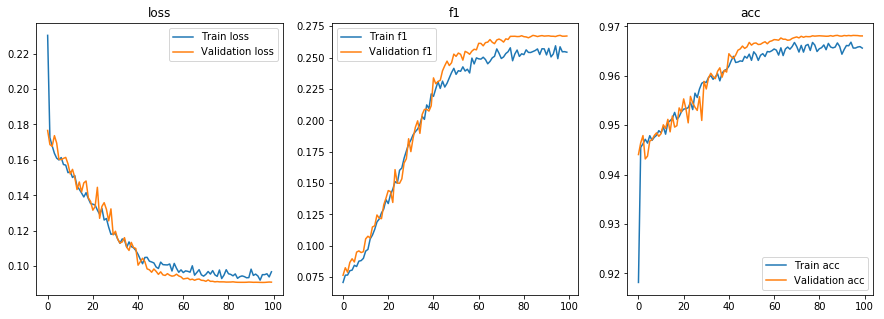

In [11]:
# Learning curve
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('f1')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train f1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation f1")
ax[2].set_title('acc')
ax[2].plot(hist.epoch, hist.history["acc"], label="Train acc")
ax[2].plot(hist.epoch, hist.history["val_acc"], label="Validation acc")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [22]:
# fine tuning
for layer in model.layers:
    layer.trainable = False
    
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True
model.layers[-7].trainable = True

model.compile(loss=f1_loss,
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy', f1])

model.fit_generator(
    trg,
    steps_per_epoch=len(trg),
    validation_data=vg,
    validation_steps=8,
    epochs=1,
    use_multiprocessing= False,
    workers=1,
    verbose=1,
    max_queue_size=4
)

Epoch 1/1


151/777 [====>.........................] - ETA: 40:06 - loss: 0.6881 - acc: 0.5938 - f1: 0.311 - ETA: 22:33 - loss: 0.6994 - acc: 0.5781 - f1: 0.300 - ETA: 16:43 - loss: 0.7298 - acc: 0.5625 - f1: 0.270 - ETA: 15:13 - loss: 0.7336 - acc: 0.5703 - f1: 0.266 - ETA: 15:03 - loss: 0.7397 - acc: 0.5875 - f1: 0.260 - ETA: 14:50 - loss: 0.7447 - acc: 0.5990 - f1: 0.255 - ETA: 14:42 - loss: 0.7406 - acc: 0.5982 - f1: 0.259 - ETA: 14:34 - loss: 0.7368 - acc: 0.5820 - f1: 0.263 - ETA: 14:25 - loss: 0.7341 - acc: 0.5868 - f1: 0.265 - ETA: 14:19 - loss: 0.7326 - acc: 0.5813 - f1: 0.267 - ETA: 14:15 - loss: 0.7341 - acc: 0.5966 - f1: 0.265 - ETA: 14:10 - loss: 0.7360 - acc: 0.5938 - f1: 0.264 - ETA: 14:05 - loss: 0.7303 - acc: 0.5889 - f1: 0.269 - ETA: 14:05 - loss: 0.7342 - acc: 0.5960 - f1: 0.265 - ETA: 14:00 - loss: 0.7338 - acc: 0.5958 - f1: 0.266 - ETA: 13:56 - loss: 0.7342 - acc: 0.6016 - f1: 0.265 - ETA: 13:55 - loss: 0.7330 - acc: 0.5974 - f1: 0.267 - ETA: 13:53 - loss: 0.7324 - acc: 0.5955

305/777 [==========>...................] - ETA: 11:20 - loss: 0.7290 - acc: 0.6051 - f1: 0.271 - ETA: 11:19 - loss: 0.7288 - acc: 0.6052 - f1: 0.271 - ETA: 11:18 - loss: 0.7291 - acc: 0.6041 - f1: 0.270 - ETA: 11:17 - loss: 0.7290 - acc: 0.6036 - f1: 0.271 - ETA: 11:16 - loss: 0.7291 - acc: 0.6038 - f1: 0.270 - ETA: 11:15 - loss: 0.7287 - acc: 0.6037 - f1: 0.271 - ETA: 11:14 - loss: 0.7284 - acc: 0.6042 - f1: 0.271 - ETA: 11:13 - loss: 0.7285 - acc: 0.6048 - f1: 0.271 - ETA: 11:12 - loss: 0.7286 - acc: 0.6035 - f1: 0.271 - ETA: 11:11 - loss: 0.7286 - acc: 0.6029 - f1: 0.271 - ETA: 11:10 - loss: 0.7283 - acc: 0.6034 - f1: 0.271 - ETA: 11:09 - loss: 0.7283 - acc: 0.6026 - f1: 0.271 - ETA: 11:08 - loss: 0.7283 - acc: 0.6018 - f1: 0.271 - ETA: 11:07 - loss: 0.7280 - acc: 0.6023 - f1: 0.272 - ETA: 11:06 - loss: 0.7281 - acc: 0.6028 - f1: 0.271 - ETA: 11:05 - loss: 0.7281 - acc: 0.6024 - f1: 0.271 - ETA: 11:04 - loss: 0.7278 - acc: 0.6025 - f1: 0.272 - ETA: 11:02 - loss: 0.7278 - acc: 0.6024

462/777 [================>.............] - ETA: 8:39 - loss: 0.7182 - acc: 0.5985 - f1: 0.28 - ETA: 8:38 - loss: 0.7180 - acc: 0.5987 - f1: 0.28 - ETA: 8:37 - loss: 0.7181 - acc: 0.5982 - f1: 0.28 - ETA: 8:36 - loss: 0.7181 - acc: 0.5984 - f1: 0.28 - ETA: 8:34 - loss: 0.7179 - acc: 0.5983 - f1: 0.28 - ETA: 8:33 - loss: 0.7180 - acc: 0.5983 - f1: 0.28 - ETA: 8:32 - loss: 0.7181 - acc: 0.5981 - f1: 0.28 - ETA: 8:31 - loss: 0.7182 - acc: 0.5976 - f1: 0.28 - ETA: 8:30 - loss: 0.7181 - acc: 0.5981 - f1: 0.28 - ETA: 8:29 - loss: 0.7180 - acc: 0.5979 - f1: 0.28 - ETA: 8:28 - loss: 0.7179 - acc: 0.5977 - f1: 0.28 - ETA: 8:27 - loss: 0.7178 - acc: 0.5976 - f1: 0.28 - ETA: 8:26 - loss: 0.7177 - acc: 0.5971 - f1: 0.28 - ETA: 8:25 - loss: 0.7178 - acc: 0.5966 - f1: 0.28 - ETA: 8:23 - loss: 0.7178 - acc: 0.5964 - f1: 0.28 - ETA: 8:22 - loss: 0.7179 - acc: 0.5964 - f1: 0.28 - ETA: 8:21 - loss: 0.7178 - acc: 0.5962 - f1: 0.28 - ETA: 8:20 - loss: 0.7178 - acc: 0.5960 - f1: 0.28 - ETA: 8:19 - loss: 0.7

619/777 [======================>.......] - ETA: 5:49 - loss: 0.7127 - acc: 0.5892 - f1: 0.28 - ETA: 5:48 - loss: 0.7126 - acc: 0.5892 - f1: 0.28 - ETA: 5:47 - loss: 0.7127 - acc: 0.5890 - f1: 0.28 - ETA: 5:46 - loss: 0.7126 - acc: 0.5891 - f1: 0.28 - ETA: 5:45 - loss: 0.7126 - acc: 0.5891 - f1: 0.28 - ETA: 5:44 - loss: 0.7126 - acc: 0.5889 - f1: 0.28 - ETA: 5:43 - loss: 0.7126 - acc: 0.5887 - f1: 0.28 - ETA: 5:41 - loss: 0.7126 - acc: 0.5889 - f1: 0.28 - ETA: 5:40 - loss: 0.7127 - acc: 0.5889 - f1: 0.28 - ETA: 5:39 - loss: 0.7127 - acc: 0.5890 - f1: 0.28 - ETA: 5:38 - loss: 0.7129 - acc: 0.5889 - f1: 0.28 - ETA: 5:37 - loss: 0.7129 - acc: 0.5886 - f1: 0.28 - ETA: 5:36 - loss: 0.7128 - acc: 0.5887 - f1: 0.28 - ETA: 5:35 - loss: 0.7128 - acc: 0.5887 - f1: 0.28 - ETA: 5:34 - loss: 0.7127 - acc: 0.5889 - f1: 0.28 - ETA: 5:33 - loss: 0.7127 - acc: 0.5888 - f1: 0.28 - ETA: 5:31 - loss: 0.7128 - acc: 0.5889 - f1: 0.28 - ETA: 5:30 - loss: 0.7129 - acc: 0.5886 - f1: 0.28 - ETA: 5:29 - loss: 0.7

777/777 [==============================] - ETA: 2:55 - loss: 0.7077 - acc: 0.5855 - f1: 0.29 - ETA: 2:54 - loss: 0.7077 - acc: 0.5857 - f1: 0.29 - ETA: 2:53 - loss: 0.7076 - acc: 0.5857 - f1: 0.29 - ETA: 2:52 - loss: 0.7076 - acc: 0.5858 - f1: 0.29 - ETA: 2:50 - loss: 0.7075 - acc: 0.5859 - f1: 0.29 - ETA: 2:49 - loss: 0.7076 - acc: 0.5859 - f1: 0.29 - ETA: 2:48 - loss: 0.7074 - acc: 0.5856 - f1: 0.29 - ETA: 2:47 - loss: 0.7074 - acc: 0.5856 - f1: 0.29 - ETA: 2:46 - loss: 0.7074 - acc: 0.5854 - f1: 0.29 - ETA: 2:45 - loss: 0.7074 - acc: 0.5856 - f1: 0.29 - ETA: 2:44 - loss: 0.7073 - acc: 0.5858 - f1: 0.29 - ETA: 2:43 - loss: 0.7073 - acc: 0.5859 - f1: 0.29 - ETA: 2:41 - loss: 0.7072 - acc: 0.5857 - f1: 0.29 - ETA: 2:40 - loss: 0.7074 - acc: 0.5856 - f1: 0.29 - ETA: 2:39 - loss: 0.7073 - acc: 0.5857 - f1: 0.29 - ETA: 2:38 - loss: 0.7074 - acc: 0.5855 - f1: 0.29 - ETA: 2:37 - loss: 0.7073 - acc: 0.5853 - f1: 0.29 - ETA: 2:36 - loss: 0.7073 - acc: 0.5853 - f1: 0.29 - ETA: 2:35 - loss: 0.7

# Prediction

In [25]:
# Calculate threshold for each class
# model = load_model(DIR + 'GapNet.model', custom_objects={'f1': f1})
fullValGen = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=False, shuffle = False)
T = getOptimalT(model, fullValGen)




  0%|          | 0/195 [00:00<?, ?it/s]


  1%|          | 1/195 [00:01<04:43,  1.46s/it]


  1%|          | 2/195 [00:02<04:42,  1.47s/it]


  2%|▏         | 3/195 [00:04<04:42,  1.47s/it]


  2%|▏         | 4/195 [00:05<04:43,  1.48s/it]


  3%|▎         | 5/195 [00:07<04:41,  1.48s/it]


  3%|▎         | 6/195 [00:08<04:39,  1.48s/it]


  4%|▎         | 7/195 [00:10<04:36,  1.47s/it]


  4%|▍         | 8/195 [00:11<04:36,  1.48s/it]


  5%|▍         | 9/195 [00:13<04:34,  1.48s/it]


  5%|▌         | 10/195 [00:14<04:35,  1.49s/it]


  6%|▌         | 11/195 [00:16<04:33,  1.49s/it]


  6%|▌         | 12/195 [00:17<04:32,  1.49s/it]


  7%|▋         | 13/195 [00:19<04:31,  1.49s/it]


  7%|▋         | 14/195 [00:20<04:30,  1.49s/it]


  8%|▊         | 15/195 [00:22<04:30,  1.50s/it]


  8%|▊         | 16/195 [00:23<04:27,  1.50s/it]


  9%|▊         | 17/195 [00:25<04:26,  1.50s/it]


  9%|▉         | 18/195 [00:26<04:23,  1.49s/it]


 10%|▉         | 19/195 [00:28<04:21,  1.49s/i

 82%|████████▏ | 159/195 [03:55<00:53,  1.47s/it]


 82%|████████▏ | 160/195 [03:57<00:52,  1.49s/it]


 83%|████████▎ | 161/195 [03:58<00:50,  1.49s/it]


 83%|████████▎ | 162/195 [04:00<00:49,  1.49s/it]


 84%|████████▎ | 163/195 [04:01<00:47,  1.48s/it]


 84%|████████▍ | 164/195 [04:03<00:45,  1.47s/it]


 85%|████████▍ | 165/195 [04:04<00:44,  1.49s/it]


 85%|████████▌ | 166/195 [04:06<00:43,  1.49s/it]


 86%|████████▌ | 167/195 [04:07<00:41,  1.49s/it]


 86%|████████▌ | 168/195 [04:09<00:40,  1.49s/it]


 87%|████████▋ | 169/195 [04:10<00:38,  1.49s/it]


 87%|████████▋ | 170/195 [04:12<00:37,  1.49s/it]


 88%|████████▊ | 171/195 [04:13<00:35,  1.49s/it]


 88%|████████▊ | 172/195 [04:15<00:34,  1.48s/it]


 89%|████████▊ | 173/195 [04:16<00:32,  1.49s/it]


 89%|████████▉ | 174/195 [04:18<00:31,  1.48s/it]


 90%|████████▉ | 175/195 [04:19<00:29,  1.50s/it]


 90%|█████████ | 176/195 [04:21<00:28,  1.50s/it]


 91%|█████████ | 177/195 [04:22<00:26,  1.49s/it]


 91%|███████

 34%|███▍      | 345/1000 [00:14<00:27, 24.11it/s]


 35%|███▍      | 348/1000 [00:15<00:27, 23.96it/s]


 35%|███▌      | 351/1000 [00:15<00:27, 23.98it/s]


 35%|███▌      | 354/1000 [00:15<00:26, 23.93it/s]


 36%|███▌      | 357/1000 [00:15<00:26, 23.84it/s]


 36%|███▌      | 360/1000 [00:15<00:26, 23.89it/s]


 36%|███▋      | 363/1000 [00:15<00:26, 23.99it/s]


 37%|███▋      | 366/1000 [00:15<00:26, 24.11it/s]


 37%|███▋      | 369/1000 [00:15<00:26, 24.14it/s]


 37%|███▋      | 372/1000 [00:16<00:25, 24.22it/s]


 38%|███▊      | 375/1000 [00:16<00:25, 24.22it/s]


 38%|███▊      | 378/1000 [00:16<00:25, 24.15it/s]


 38%|███▊      | 381/1000 [00:16<00:25, 24.05it/s]


 38%|███▊      | 384/1000 [00:16<00:25, 24.10it/s]


 39%|███▊      | 387/1000 [00:16<00:25, 24.13it/s]


 39%|███▉      | 390/1000 [00:16<00:25, 24.27it/s]


 39%|███▉      | 393/1000 [00:16<00:25, 24.13it/s]


 40%|███▉      | 396/1000 [00:17<00:24, 24.22it/s]


 40%|███▉      | 399/1000 [00:17<00:24, 24.15i

 81%|████████  | 807/1000 [00:34<00:07, 24.22it/s]


 81%|████████  | 810/1000 [00:34<00:07, 24.39it/s]


 81%|████████▏ | 813/1000 [00:34<00:07, 24.46it/s]


 82%|████████▏ | 816/1000 [00:34<00:07, 24.14it/s]


 82%|████████▏ | 819/1000 [00:34<00:07, 24.22it/s]


 82%|████████▏ | 822/1000 [00:34<00:07, 24.22it/s]


 82%|████████▎ | 825/1000 [00:34<00:07, 23.64it/s]


 83%|████████▎ | 828/1000 [00:35<00:07, 23.15it/s]


 83%|████████▎ | 831/1000 [00:35<00:07, 23.24it/s]


 83%|████████▎ | 834/1000 [00:35<00:07, 23.41it/s]


 84%|████████▎ | 837/1000 [00:35<00:06, 23.48it/s]


 84%|████████▍ | 840/1000 [00:35<00:06, 23.14it/s]


 84%|████████▍ | 843/1000 [00:35<00:06, 23.23it/s]


 85%|████████▍ | 846/1000 [00:35<00:06, 23.19it/s]


 85%|████████▍ | 849/1000 [00:35<00:06, 23.49it/s]


 85%|████████▌ | 852/1000 [00:36<00:06, 22.68it/s]


 86%|████████▌ | 855/1000 [00:36<00:06, 22.70it/s]


 86%|████████▌ | 858/1000 [00:36<00:06, 22.11it/s]


 86%|████████▌ | 861/1000 [00:36<00:06, 22.29i

[0.627 0.637 0.583 0.46  0.558 0.412 0.668 0.602 0.539 0.924 0.925 0.614
 0.83  0.959 0.563 0.    0.268 0.949 0.727 0.306 0.621 0.519 0.746 0.636
 0.873 0.575 0.792 0.004]


In [26]:
# Give predictions based on probability and threshold of each class
pathsTest, labelsTest = getTestDataset()

teg = ProteinDataGenerator(pathsTest, labelsTest, BATCH_SIZE, SHAPE)
submit = pd.read_csv(DIR + 'sample_submission.csv')
P = np.zeros((pathsTest.shape[0], NUM_CLASS))
for i in tqdm(range(len(teg))):
    images, labels = teg[i]
    score = model.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

PP = np.array(P)
prediction = []

for row in tqdm(range(submit.shape[0])):
    str_label = ''
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]+1e-4):   # Add a small epsilon to avoid the case a label always exists when its threshold is 0
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())




  0%|          | 0/366 [00:00<?, ?it/s]


  0%|          | 1/366 [00:01<10:02,  1.65s/it]


  1%|          | 2/366 [00:03<10:05,  1.66s/it]


  1%|          | 3/366 [00:05<10:07,  1.67s/it]


  1%|          | 4/366 [00:06<10:08,  1.68s/it]


  1%|▏         | 5/366 [00:08<10:11,  1.70s/it]


  2%|▏         | 6/366 [00:10<10:11,  1.70s/it]


  2%|▏         | 7/366 [00:11<10:12,  1.71s/it]


  2%|▏         | 8/366 [00:13<10:07,  1.70s/it]


  2%|▏         | 9/366 [00:15<10:08,  1.70s/it]


  3%|▎         | 10/366 [00:16<10:05,  1.70s/it]


  3%|▎         | 11/366 [00:18<10:10,  1.72s/it]


  3%|▎         | 12/366 [00:20<10:05,  1.71s/it]


  4%|▎         | 13/366 [00:22<10:01,  1.70s/it]


  4%|▍         | 14/366 [00:23<09:59,  1.70s/it]


  4%|▍         | 15/366 [00:25<09:51,  1.68s/it]


  4%|▍         | 16/366 [00:27<09:56,  1.70s/it]


  5%|▍         | 17/366 [00:28<09:48,  1.69s/it]


  5%|▍         | 18/366 [00:30<09:48,  1.69s/it]


  5%|▌         | 19/366 [00:32<09:47,  1.69s/i

 43%|████▎     | 159/366 [04:31<05:51,  1.70s/it]


 44%|████▎     | 160/366 [04:33<05:51,  1.71s/it]


 44%|████▍     | 161/366 [04:34<05:49,  1.70s/it]


 44%|████▍     | 162/366 [04:36<05:47,  1.70s/it]


 45%|████▍     | 163/366 [04:38<05:45,  1.70s/it]


 45%|████▍     | 164/366 [04:39<05:43,  1.70s/it]


 45%|████▌     | 165/366 [04:41<05:41,  1.70s/it]


 45%|████▌     | 166/366 [04:43<05:40,  1.70s/it]


 46%|████▌     | 167/366 [04:44<05:38,  1.70s/it]


 46%|████▌     | 168/366 [04:46<05:37,  1.70s/it]


 46%|████▌     | 169/366 [04:48<05:36,  1.71s/it]


 46%|████▋     | 170/366 [04:50<05:33,  1.70s/it]


 47%|████▋     | 171/366 [04:51<05:31,  1.70s/it]


 47%|████▋     | 172/366 [04:53<05:30,  1.70s/it]


 47%|████▋     | 173/366 [04:55<05:31,  1.72s/it]


 48%|████▊     | 174/366 [04:56<05:30,  1.72s/it]


 48%|████▊     | 175/366 [04:58<05:28,  1.72s/it]


 48%|████▊     | 176/366 [05:00<05:24,  1.71s/it]


 48%|████▊     | 177/366 [05:02<05:22,  1.71s/it]


 49%|████▊  

 86%|████████▋ | 316/366 [08:59<01:25,  1.71s/it]


 87%|████████▋ | 317/366 [09:00<01:23,  1.71s/it]


 87%|████████▋ | 318/366 [09:02<01:21,  1.71s/it]


 87%|████████▋ | 319/366 [09:04<01:19,  1.70s/it]


 87%|████████▋ | 320/366 [09:05<01:18,  1.71s/it]


 88%|████████▊ | 321/366 [09:07<01:17,  1.72s/it]


 88%|████████▊ | 322/366 [09:09<01:15,  1.71s/it]


 88%|████████▊ | 323/366 [09:10<01:13,  1.71s/it]


 89%|████████▊ | 324/366 [09:12<01:11,  1.71s/it]


 89%|████████▉ | 325/366 [09:14<01:10,  1.72s/it]


 89%|████████▉ | 326/366 [09:16<01:08,  1.72s/it]


 89%|████████▉ | 327/366 [09:17<01:06,  1.70s/it]


 90%|████████▉ | 328/366 [09:19<01:04,  1.70s/it]


 90%|████████▉ | 329/366 [09:21<01:02,  1.70s/it]


 90%|█████████ | 330/366 [09:22<01:01,  1.71s/it]


 90%|█████████ | 331/366 [09:24<00:59,  1.71s/it]


 91%|█████████ | 332/366 [09:26<00:58,  1.71s/it]


 91%|█████████ | 333/366 [09:28<00:56,  1.71s/it]


 91%|█████████▏| 334/366 [09:29<00:54,  1.70s/it]


 92%|███████

In [27]:
submit['Predicted'] = prediction
submit.to_csv('submission.csv', index=False)